# The First-order implied volatility expansion for the VIX option under the forward variance framework

## 1. Single Exponential Models

In the single exponential forward variance model, the VIX option price can be approximated using the following formula
\begin{align*}
\mathbb{E} \left[ \varphi \left(\mathrm{VIX}_T^2\right) \right] = \mathbb{E} \left[ \varphi \left(\mathrm{VIX}_{T,P}^2\right) \right] + \sum_{i=1}^3 \gamma_i \mathcal{G}_i^\varphi \left(\mathrm{VIX}_{T,P}^2\right) + \mathcal{E}_\varphi,
\end{align*}
where $\mathcal{E}_\varphi$ is an error term and the cofficients $(\gamma_i)_{i=\{1,2,3\}}$ are deterministic depending on the kernel defined in the instantaneous forward variance process. This formula can be re-expressed using the Black-Scholes price function and its derivatives with respect to the log-spot price. The rewritten formula for the VIX call, put and futures are given as follow
1. VIX call
\begin{align*}
c_{\mathrm{VIX}_T}
&:= C^{\text{BS}} \left(x_P, \log(\kappa), \frac{\widetilde{\sigma}}{2}\right) + \frac{\gamma_1}{2} \partial_x C^{\text{BS}} \left(x_P, \log(\kappa), \frac{\widetilde{\sigma}}{2}\right) + \frac{\gamma_2}{4} \partial_x^2 C^{\text{BS}} \left(x_P, \log(\kappa), \frac{ \widetilde{\sigma}}{2}\right) + \frac{\gamma_3}{8} \partial_x^3 C^{\text{BS}} \left(x_P, \log(\kappa), \frac{1}{2} \widetilde{\sigma}\right),
\end{align*}
where 
\begin{align*}
x_P := \frac{\mu_P}{2} + \frac{\sigma_P^2}{8}, && \widetilde{\sigma} = \frac{\sigma_P}{\sqrt{T}}.
\end{align*}
2. VIX put option
\begin{align*}
p_{\mathrm{VIX}_T}
&:= P^{\text{BS}} \left( x_P, \log(\kappa), \frac{\widetilde{\sigma}}{2}\right) + \frac{\gamma_1}{2} \partial_x P^{\text{BS}} \left(x_P, \log(\kappa), \frac{\widetilde{\sigma}}{2}\right) + \frac{\gamma_2}{4} \partial_x^2 P^{\text{BS}} \left(x_P, \log(\kappa), \frac{\widetilde{\sigma}}{2} \right) + \frac{\gamma_3}{8} \partial_x^3 P^{\text{BS}} \left(x_P, \log(\kappa), \frac{\widetilde{\sigma}}{2}\right)
\end{align*}
2. VIX futures
\begin{align*}
F_{\mathrm{VIX}_T} := \mathrm{e}^{x_P} + \frac{\gamma_1}{2} \mathrm{e}^{x_P} + \frac{\gamma_2}{4} \mathrm{e}^{x_P} + \frac{\gamma_3}{8} \mathrm{e}^{x_P}.
\end{align*}

Thus, the first-order approximation of VIX implied volatility in the single exponential model is given by
\begin{align*}
\bar{\sigma}_I = \frac{\widetilde{\sigma}}{2} + \frac{\gamma_2}{2 \widetilde{\sigma} T} + \frac{3 \gamma_3}{8 \widetilde{\sigma} T} - \frac{\gamma_3}{\widetilde{\sigma}^3 T^2} \left(x_P - \log(\kappa)\right).
\end{align*}

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import utils
from standard_bergomi import StandardBergomi
from rough_bergomi import RoughBergomi
import seaborn as sns

sns.set_theme("talk")

SEED = 777
maturities = {
    "1M": 1.0 / 12.0,
    "3M": 3.0 / 12.0,
    "6M": 6.0 / 12.0
}

### 1.1VIX implied volatility with respect to the moneyness $m = \frac{\log (\kappa/ F)}{\sigma_{\text{ATM}} \sqrt{T}}$ in the standard Bergomi model

In [3]:
params_b = {
    "omega":2,
    "k":0.5,
    "xi0": lambda u: np.ones_like(u) * 0.235**2
}

n_time = 80
n_space = 80

b = StandardBergomi(**params_b)

In [4]:
m = np.linspace(-0.1, 0.4, 10)

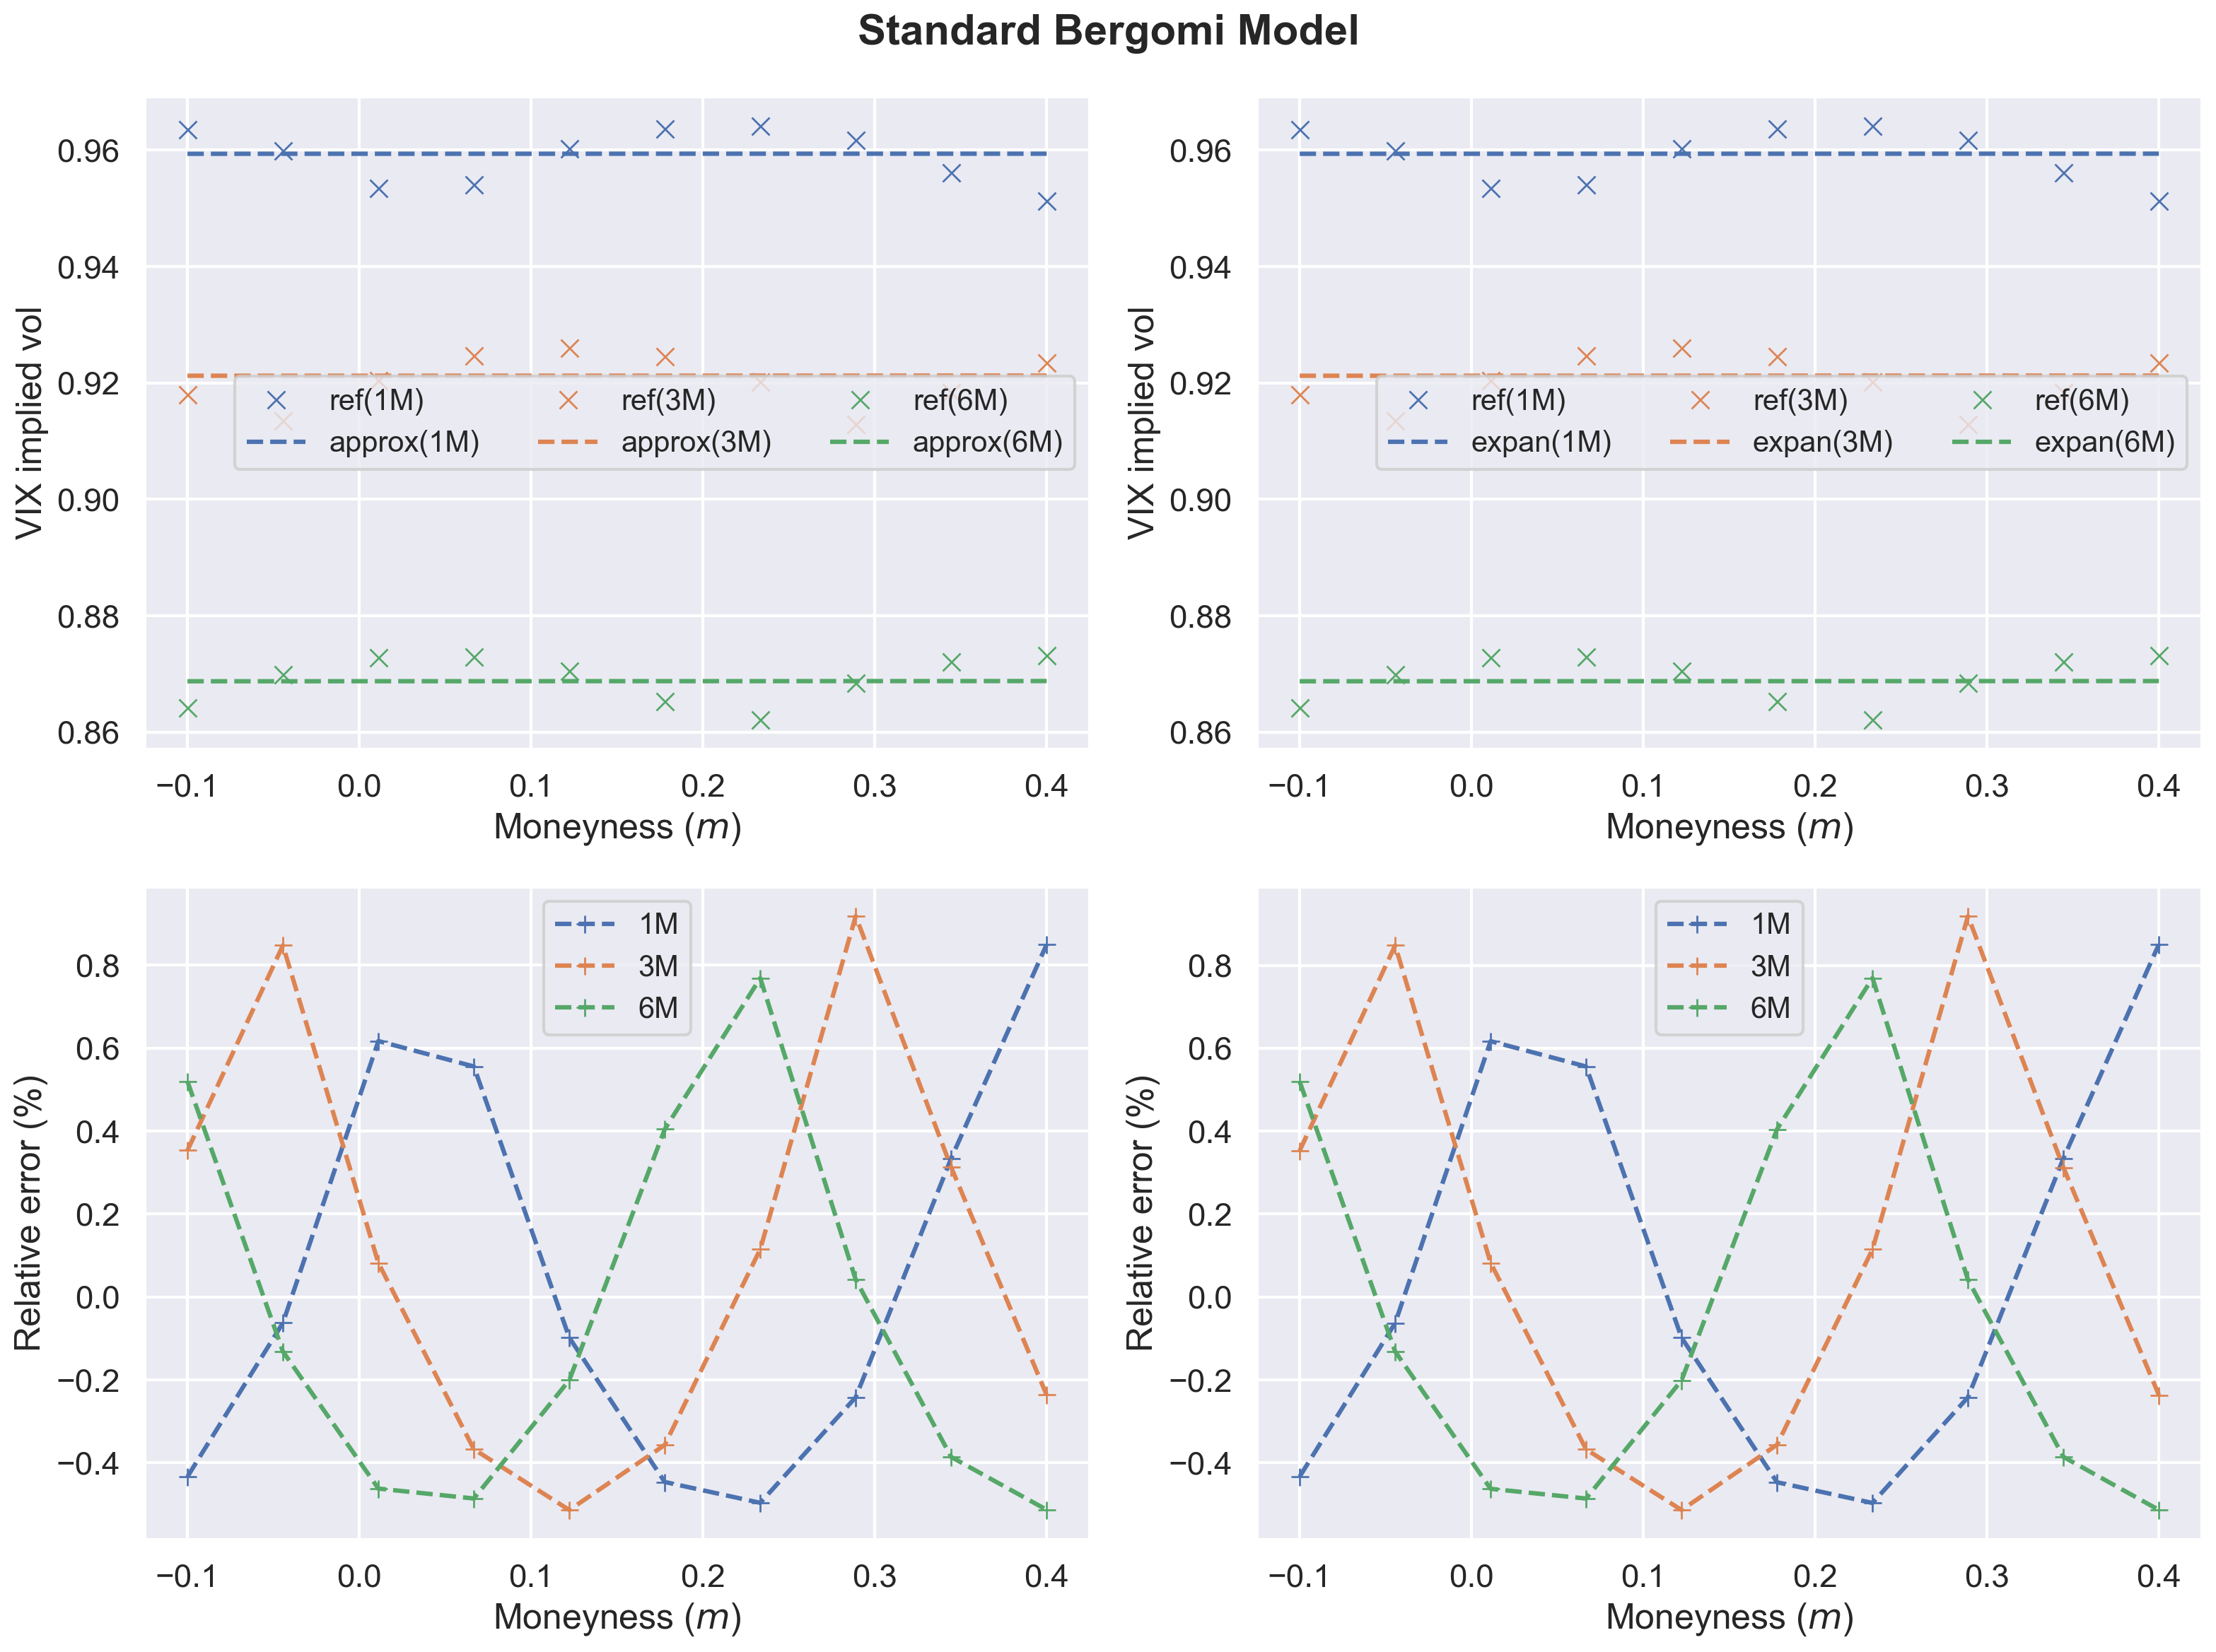

In [5]:
calc_methods = {
    "Ref":   ("vix_implied_vol", True),
    "Proxy": ("implied_vol_proxy", False),
    "Expan": ("implied_vol_expan", False)
}

results = {}
for label, (method_name, is_quadrature) in calc_methods.items():

    method = getattr(b, method_name)
    if is_quadrature:
        atm_iv = {mat: method(0, T, n_space, n_time) for mat, T in maturities.items()}
    else:
        atm_iv = {mat: method(0, T) for mat, T in maturities.items()}
            
    k_val = {mat: m * atm_iv[mat] * np.sqrt(T) for mat, T in maturities.items()}
        
    if is_quadrature:
        results[label] = {mat: method(k_val[mat], T, n_space, n_time) for mat, T in maturities.items()}
    else:
        results[label] = {mat: method(k_val[mat], T) for mat, T in maturities.items()}

utils.plot_style_4(
    m, maturities, 
    results["Ref"], results["Proxy"], results["Expan"], 
    "Moneyness ($m$)", "VIX implied vol", "Standard Bergomi Model"
)

### 1.2 VIX implied volatility with respect to the moneyness $m = \frac{\log (\kappa/ F)}{\sigma_{\text{ATM}} \sqrt{T}}$ in the rough Bergomi model

In [6]:
params_rb = {
    "eta": 1,
    "H": 0.1,
    "xi0": lambda u: np.ones_like(u) * 0.235**2
}

n_disc = 300
n_mc = 10**6

rb = RoughBergomi(**params_rb)

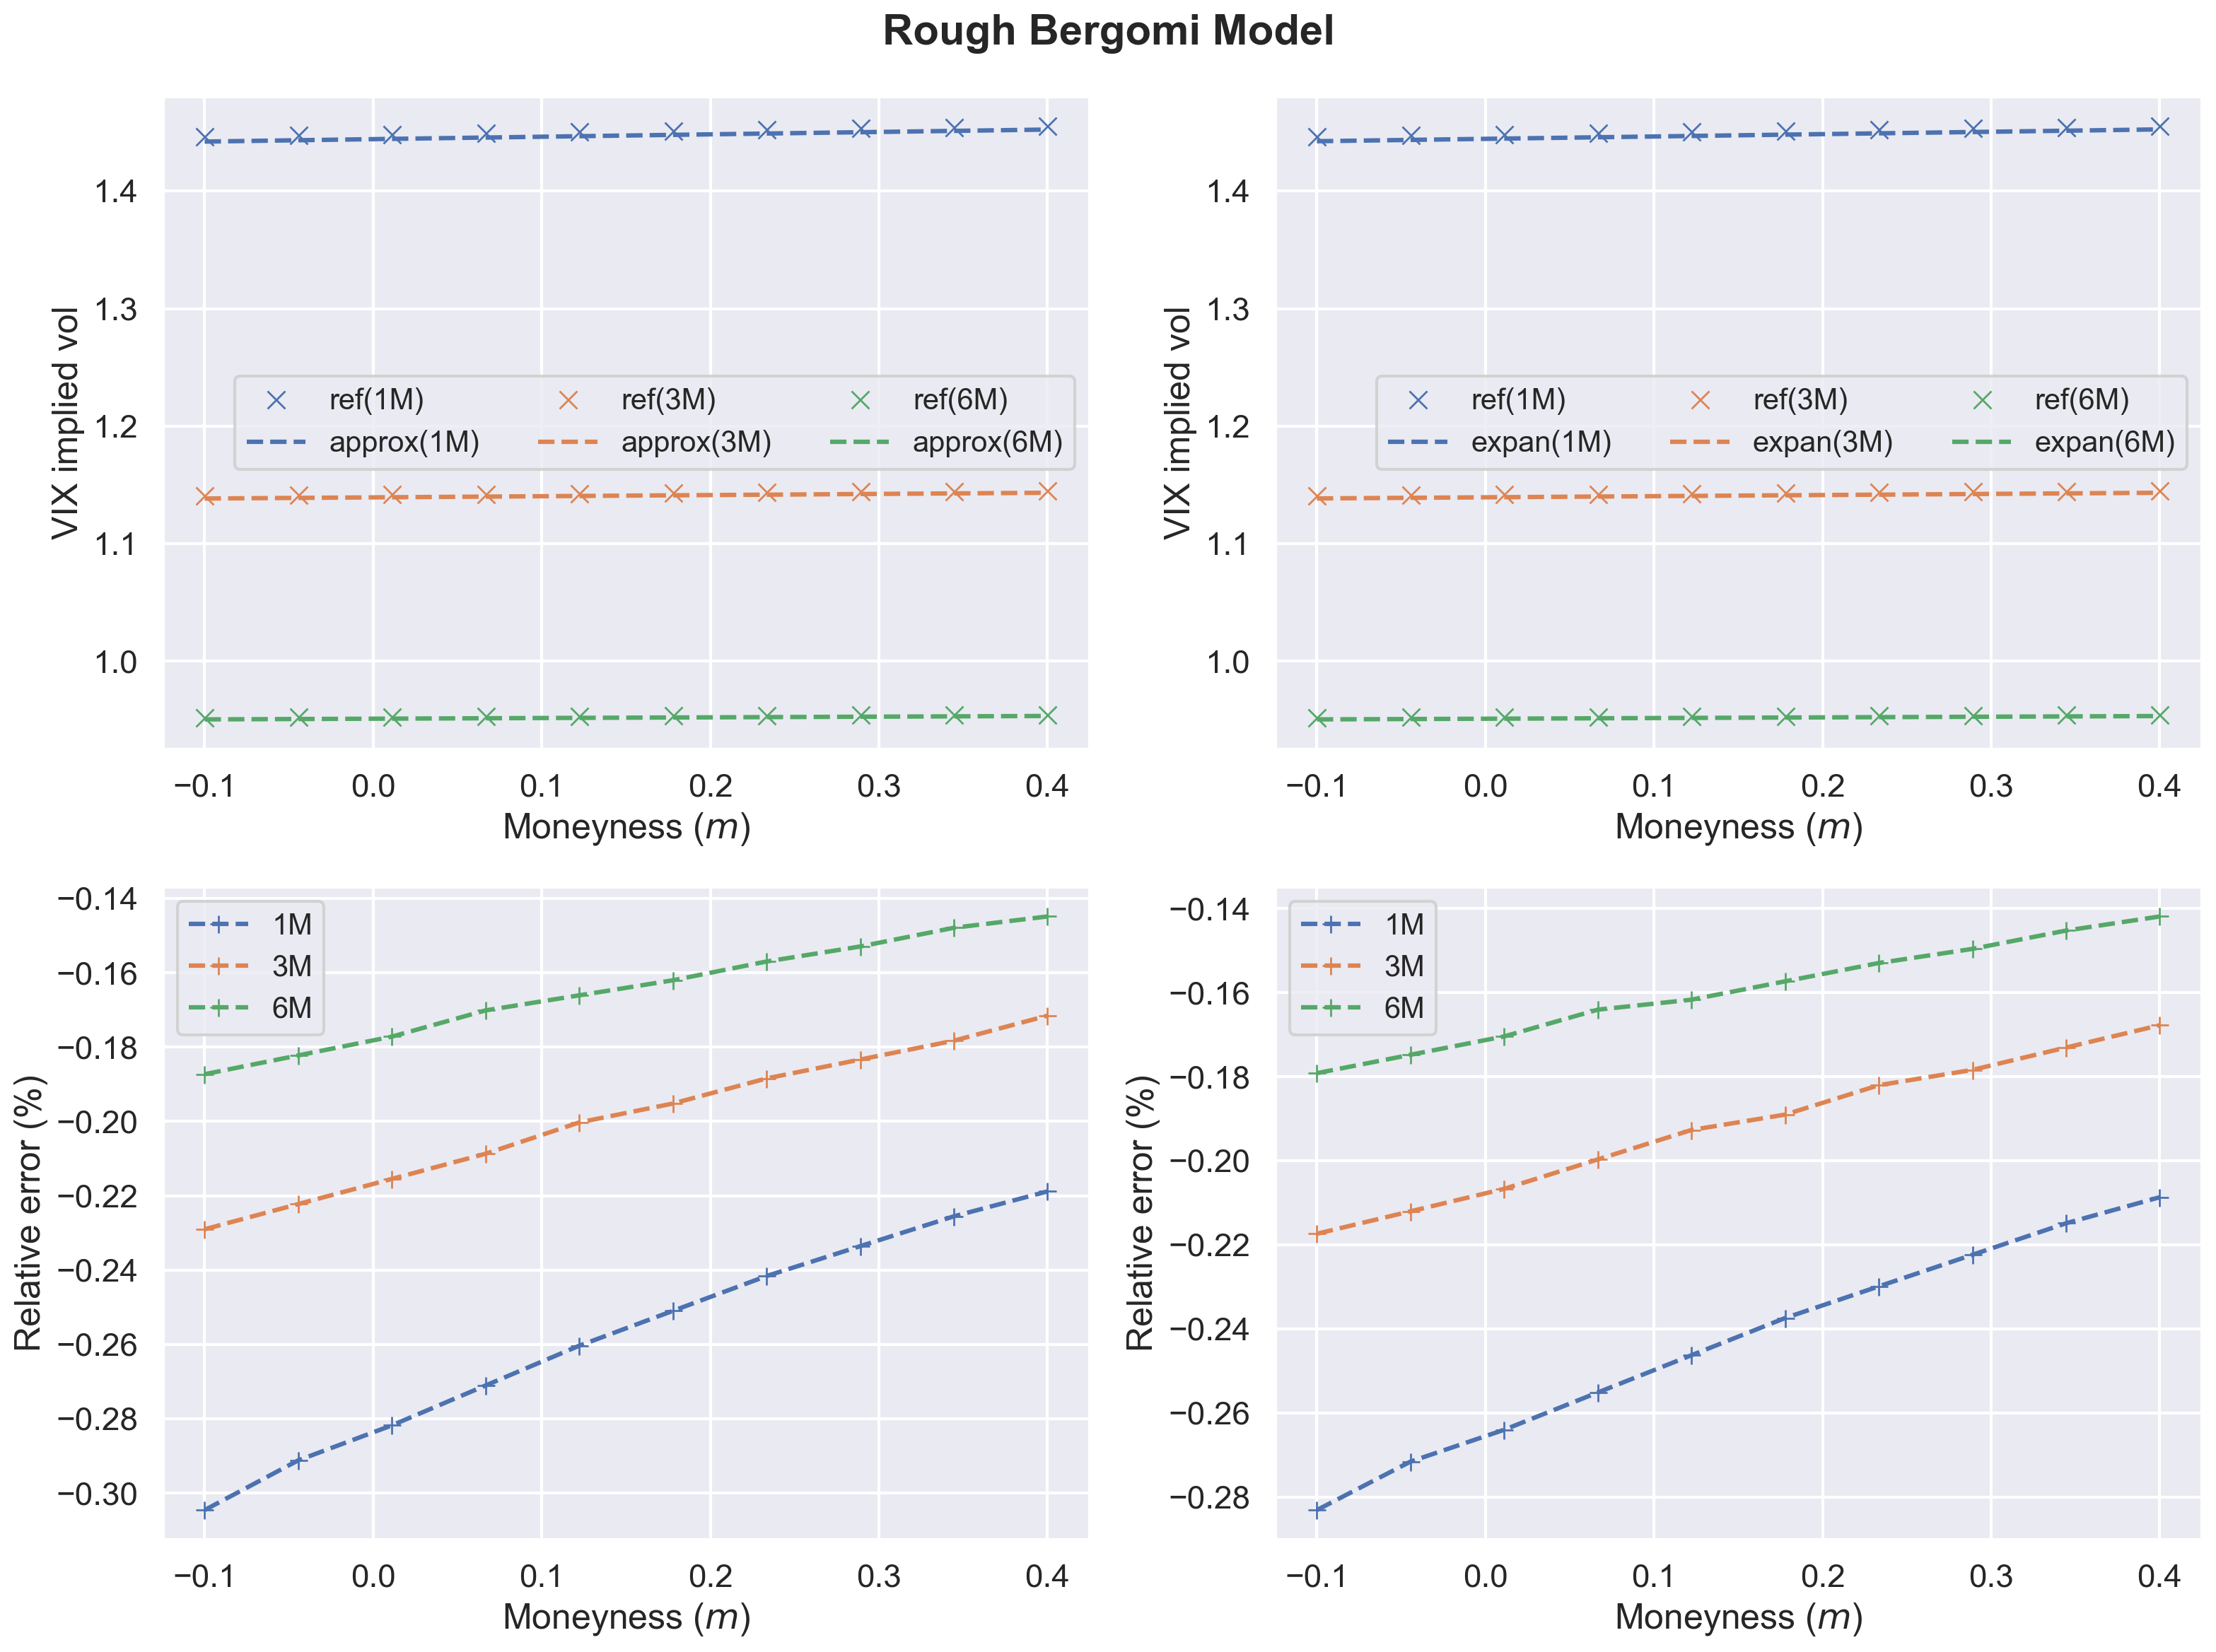

In [7]:
results = {}
for label, (method_name, is_mc) in calc_methods.items():

    method = getattr(rb, method_name)
    if is_mc:
        atm_iv = {mat: method(0, T, n_disc, n_mc, SEED) for mat, T in maturities.items()}
    else:
        atm_iv = {mat: method(0, T) for mat, T in maturities.items()}
            
    k_val = {mat: m * atm_iv[mat] * np.sqrt(T) for mat, T in maturities.items()}
        
    if is_mc:
        results[label] = {mat: method(k_val[mat], T, n_disc, n_mc, SEED) for mat, T in maturities.items()}
    else:
        results[label] = {mat: method(k_val[mat], T) for mat, T in maturities.items()}

utils.plot_style_4(
    m, maturities, 
    results["Ref"], results["Proxy"], results["Expan"], 
    "Moneyness ($m$)", "VIX implied vol", "Rough Bergomi Model"
)

### 1.3 Computation time of the explicit VIX implied volatility approximation

In [8]:
import time
k0 = 0.1
T = 3.0 / 12.0

In [9]:
start = time.perf_counter()
b.implied_vol_proxy(k0, T)
elapsed = time.perf_counter() - start
print(f"The root-finding method took {elapsed*1000:.6f} ms.")

start = time.perf_counter()
b.implied_vol_expan(k0, T)
elapsed = time.perf_counter() - start
print(f"The closed-form formula took {elapsed*1000:.6f} ms.")

The root-finding method took 1.597900 ms.
The closed-form formula took 0.069300 ms.


In [10]:
start = time.perf_counter()
rb.implied_vol_proxy(k0, T)
elapsed = time.perf_counter() - start
print(f"The root-finding method took {elapsed*1000:.6f} ms.")

start = time.perf_counter()
rb.implied_vol_expan(k0, T)
elapsed = time.perf_counter() - start
print(f"The closed-form formula took {elapsed*1000:.6f} ms.")

The root-finding method took 815.564400 ms.
The closed-form formula took 792.885800 ms.


## 2. Mixed Exponential Models

In the mixed class of exponential forward variance models, the VIX option price can be approximated using the following formula
\begin{align}
\mathbb{E} \left[ \varphi \left(\text{VIX}_T^2\right) \right] = \mathbb{E} \left[ \varphi \left(\text{VIX}_{T,P}^2\right) \right] + \sum_{i=1}^3 \sum_{j=1}^2 \gamma_{i,j} P_{i.j} + \mathcal{E}_\varphi,
\end{align}
where $\mathcal{E}_\varphi$ is an error term and the cofficients $(\gamma_{i,j})_{i=\{1,2,3\}, j = \{1,2\}}$ are deterministic depending on the kernel defined in the instantaneous forward variance process. There exists no closed-form formulas for correction terms, even under the flat initial forward variance curve assumption. We expand this formula using the probabilist's Hermite polynomial.
1. VIX call
\begin{align*}
P_N^\text{Call} &:= c_0 \bar{I}_N (B) + c_1 \bar{I}_{1,N} (B) + c_2 \bar{I}_{2,N} (B) + c_3 \bar{I}_{3,N} (B) - \kappa \Phi(-A),
\end{align*}
where the coefficients $(c_i)_{i = 0, 1, 2, 3}$ are given by
\begin{align*}
c_0 &:= \left(1 + \frac{1}{2} \gamma_{1,2} + \frac{1}{4} \gamma_{2,2} + \frac{1}{8} \gamma_{3,2} \right) a\\
c_1 &:= \left(\gamma_{1,1} - \gamma_{1,2} + \gamma_{2,1} \frac{\sigma_{P,2}}{2 \sigma_{P,1}} - \gamma_{2,2} \left(1 - \frac{\sigma_{P,1}}{2 \sigma_{P,2}} \right) + \gamma_{3,1} \frac{\sigma_{P,2}^2}{4 \sigma_{P,1}^2} - \gamma_{3,2} \left(\frac{3}{4} - \frac{\sigma_{P,1}}{2 \sigma_{P,2}}\right) \right) a,\\
c_2 &:= \left(\gamma_{2,1} \left(1 - \frac{\sigma_{P,2}}{\sigma_{P,1}} \right) + \gamma_{2,2} \left(1 -  \frac{\sigma_{P,1}}{\sigma_{P,2}}\right) + \gamma_{3,1} \left( \frac{\sigma_{P,2}}{\sigma_{P,1}} - \frac{\sigma_{P,2}^2}{\sigma_{P,1}^2} \right) + \gamma_{3,2} \left( \frac{3}{2} - \frac{2 \sigma_{P,1}}{\sigma_{P,2}} + \frac{\sigma_{P,1}^2}{2\sigma_{P,2}^2} \right) \right) a\\
c_3 &:= \left(\gamma_{3,1} \left(1 - \frac{2 \sigma_{P,2}}{\sigma_{P,1}} + \frac{\sigma_{P,2}^2}{\sigma_{P,1}^2} \right) - \gamma_{3,2} \left(1 - \frac{2 \sigma_{P,1}}{\sigma_{P,2}} + \frac{\sigma_{P,1}^2}{\sigma_{P,2}^2} \right)\right) a,
\end{align*}
and the partial derivatives of $\bar{I}_N (B)$ with respect to $\mu_{P,1}$ are derived as follows
\begin{align*}
\bar{I}_{i,N} (B) &:= \partial_{\mu_{P,1}}^i \omega_0 \Phi(-B) + \sum_{n=1}^N \partial_{\mu_{P,1}}^i \omega_n \text{He}_{n-1} (B) \phi (B).
\end{align*}
2. VIX futures
\begin{align*}
P^F = c_0 \omega_0 + c_1 \partial_{\mu_{P,1}} \omega_0 + c_2 \partial_{\mu_{P,1}}^2 \omega_0 + c_3 \partial_{\mu_{P,1}}^3 \omega_0.
\end{align*}

There are three different expression for the VIX implied volatility approxiamtion based on different rewritten form of the VIX option price approxiamtion using the Black-Schole price formula and its derivatives.
1. Introduce a new log-spot price and keep the strike price unchange. 
\begin{align*}
\bar{\sigma}_I = \frac{1}{2} \widetilde{\sigma} + \frac{1}{\text{e}^{x_1} \sqrt{T}} \sum_{n=1}^N \left(c_0 \omega_n + c_1 \partial_{\mu_{P,1}} \omega_n + c_2 \partial_{\mu_{P,1}}^2 \omega_n + c_3 \partial_{\mu_{P,1}}^3 \omega_n \right) \text{He}_{n-1} (B),
\end{align*}
where
\begin{align*}
x_1 := k_1 - \frac{B \sigma_{P,2}}{2} - \frac{\sigma_{P,2}^2}{8},&& k_1 = \ln (\kappa), && \widetilde{\sigma} := \frac{\sigma_{P,2}}{\sqrt{T}}.
\end{align*}
2. Keep the spot price fixed and introduce a new log-strike price.
\begin{align*}
\bar{\sigma}_I = \frac{1}{2} \widetilde{\sigma} + \frac{1}{\text{e}^{x_2} \sqrt{T}} \sum_{n=1}^N \left(c_0 \omega_n + c_1 \partial_{\mu_{P,1}} \omega_n + c_2 \partial_{\mu_{P,1}}^2 \omega_n + c_3 \partial_{\mu_{P,1}}^3 \omega_n \right) \text{He}_{n-1} (B),
\end{align*}
where
\begin{align*}
x_2 := \ln \left(P^F\right), && k_2 := \ln \left(P^F\right) + \frac{B \sigma_{P,2}}{2} + \frac{\sigma_{P,2}^2}{8},  && \widetilde{\sigma} := \frac{\sigma_{P,2}}{\sqrt{T}}.
\end{align*}
3. Introduce both a new log-spot price and a new log-strike price.
\begin{align*}
\bar{\sigma}_I = \frac{1}{2} \widetilde{\sigma} + \frac{1}{\text{e}^{\tilde{x}} \sqrt{T}} \sum_{n=1}^N \left(c_0 \omega_n + c_1 \partial_{\mu_{P,1}} \omega_n + c_2 \partial_{\mu_{P,1}}^2 \omega_n + c_3 \partial_{\mu_{P,1}}^3 \omega_n \right) \text{He}_{n-1} (B),
\end{align*}
where
\begin{align*}
\tilde{x} := \frac{1}{2} \left(x_1 + x_2 \right), && \tilde{k} := \frac{1}{2} \left( k_1 + k_2 \right),  && \widetilde{\sigma} := \frac{\sigma_{P,2}}{\sqrt{T}}.
\end{align*}


### 2.1 VIX call option price with respect to the strike price $\kappa$ in the mixed standard Bergomi model

In [11]:
params_mb = {
    "omega": 10,
    "k": 1,
    "xi0": lambda u: np.ones_like(u) * 0.2**2,
}
omega2 = 2
lbd = 0.2

n_time = 80
n_space = 80
n_gauss = 80
n_max = 20
n_mc = 10**6

mb = StandardBergomi(**params_mb)

According to the assumption in Corollary 4.2, we rewrite the VIX option price approximation based on the smaller volatility.

In [12]:
rule = -1
kappa = np.linspace(0.1, 0.4, 10)

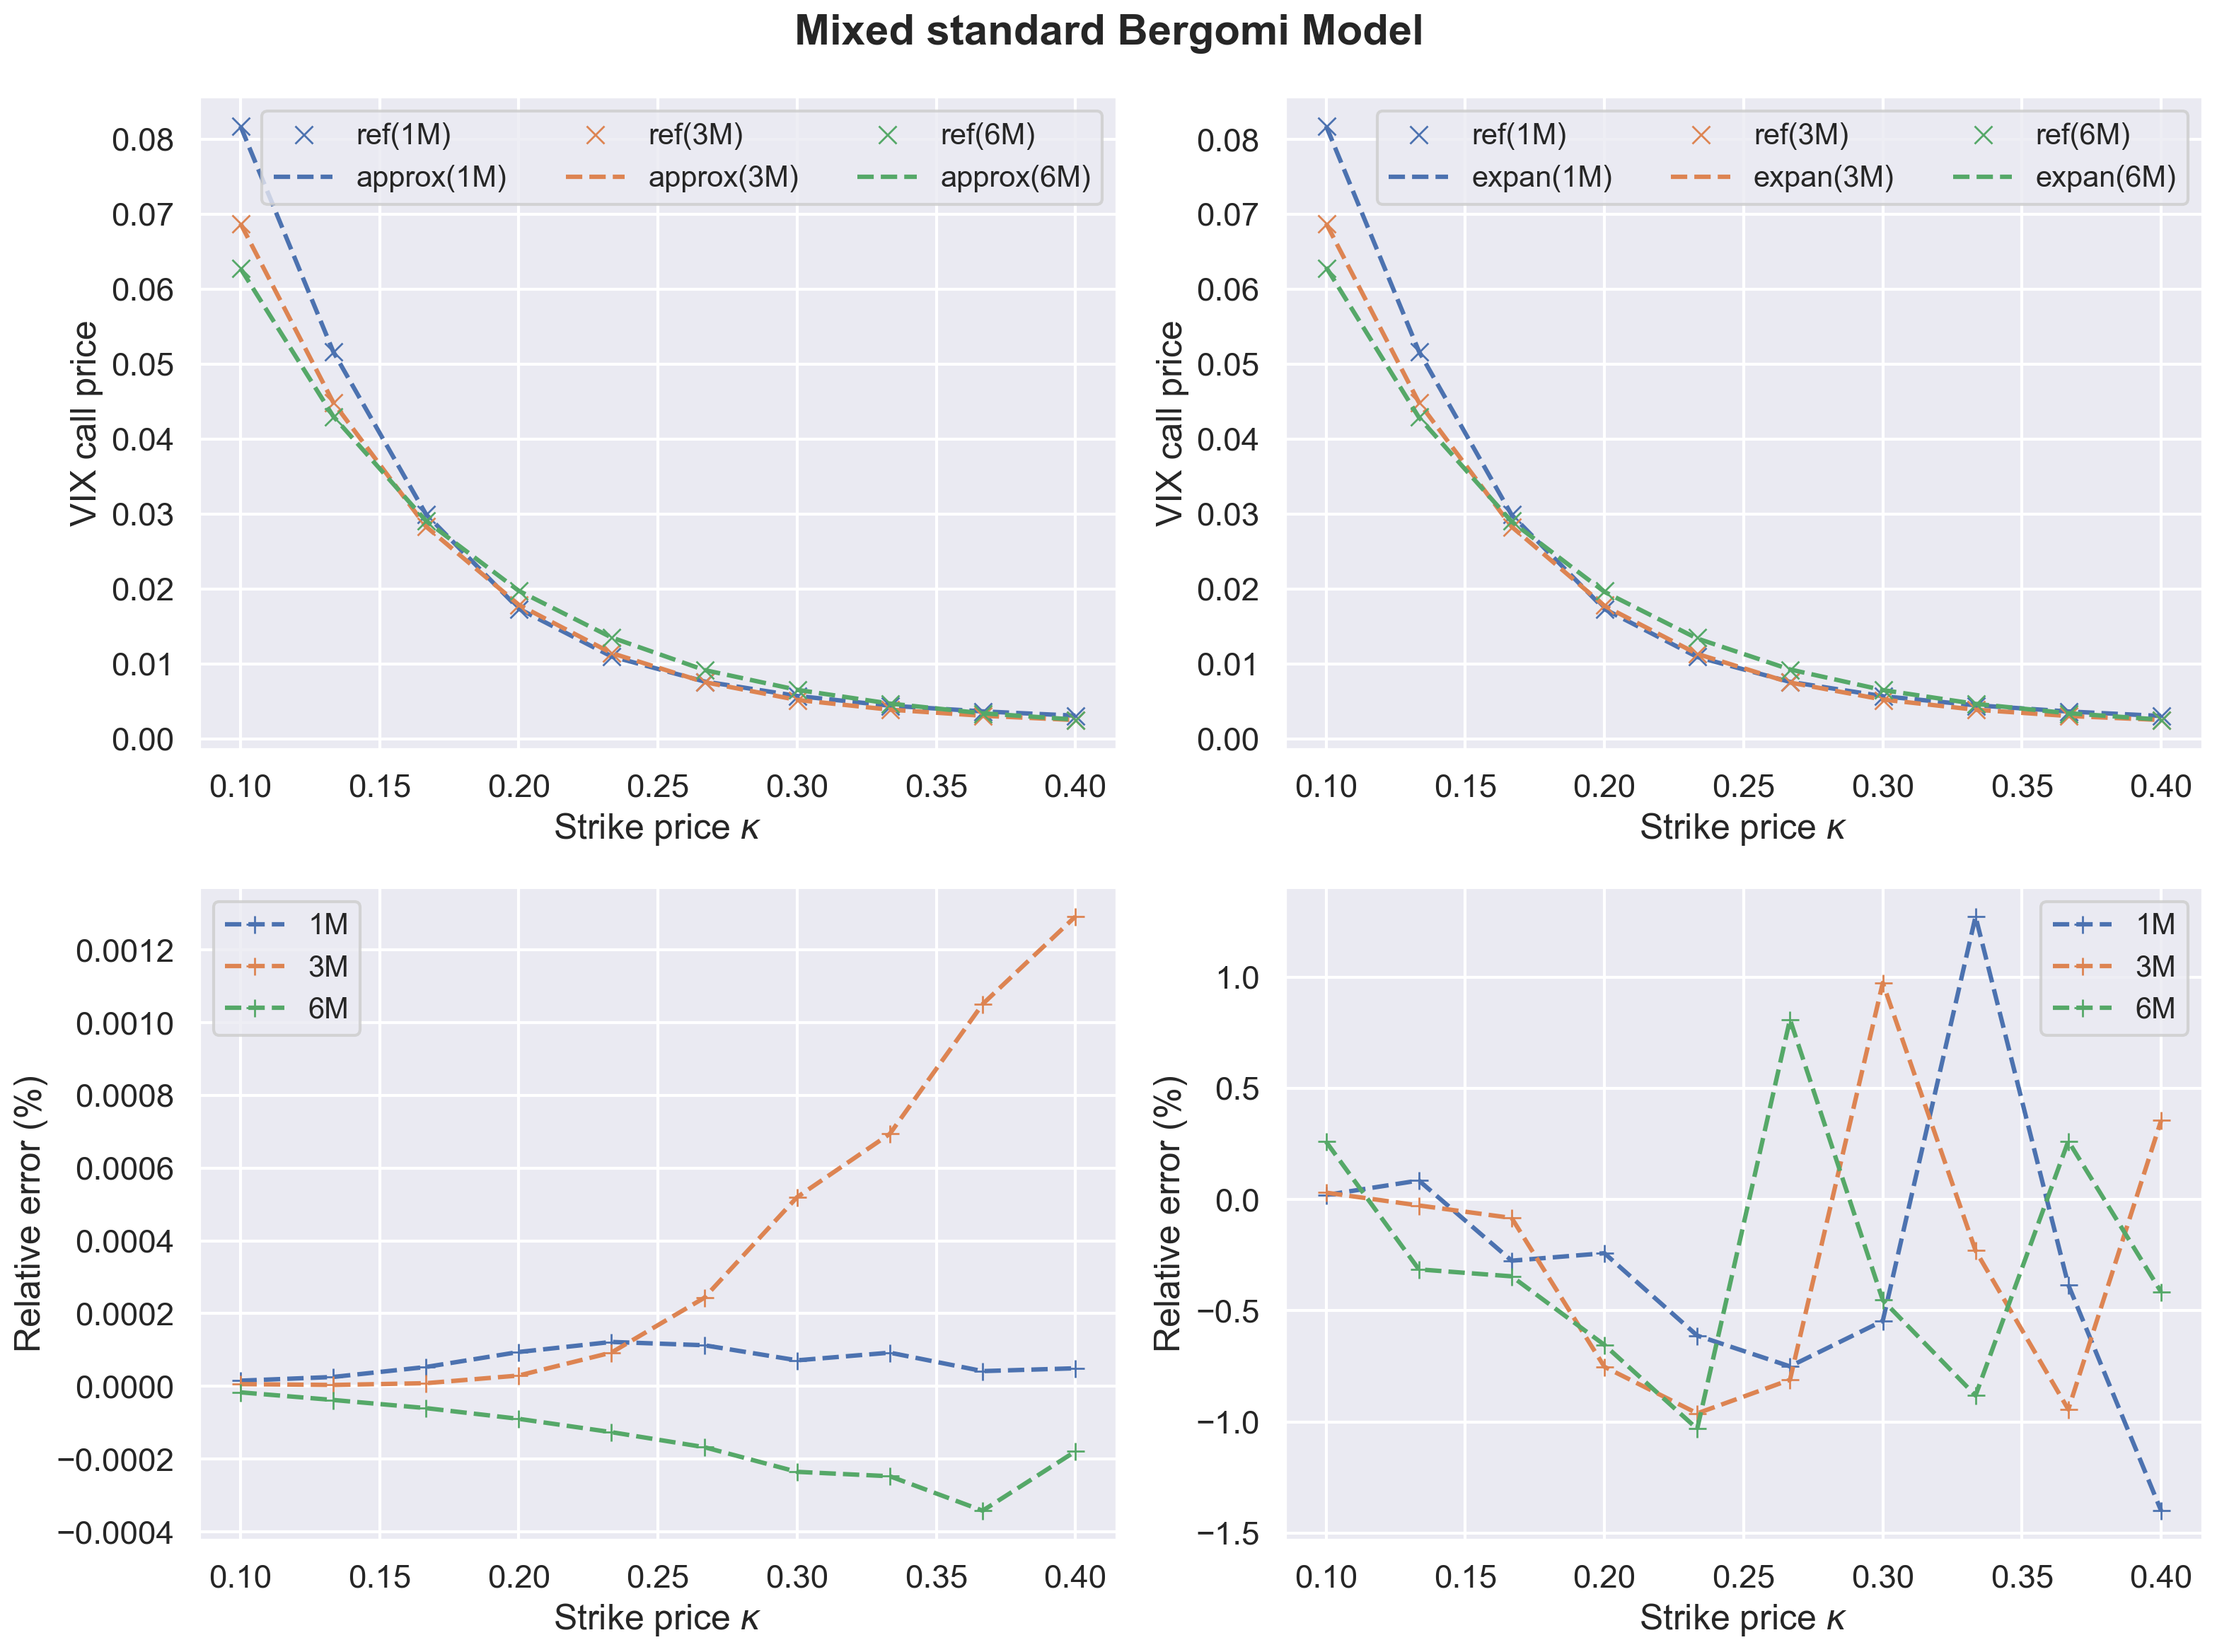

In [13]:
price_ref = {
    maturity: mb.vix_opt_price_mixed(kappa, T, omega2, lbd, opttype=1, n_time=n_time, n_space=n_space) for maturity, T in maturities.items()
}

price_proxy = {
    maturity: mb.vix_opt_price_proxy_mixed(kappa, T, omega2, lbd, opttype=1, n_gauss=n_gauss) for maturity, T in maturities.items()
}

price_expan = {
    maturity: mb.vix_opt_price_expan_mixed(kappa, T, rule, omega2, lbd, opttype=1, n_max=n_max, n_mc=n_mc) for maturity, T in maturities.items()
}

utils.plot_style_4(kappa, maturities, price_ref, price_proxy, price_expan, r"Strike price $\kappa$", "VIX call price", "Mixed standard Bergomi Model")

### 2.2 VIX implied volatility with respect to the moneyness $m = \frac{\log (\kappa/ F)}{\sigma_{\text{ATM}} \sqrt{T}}$ in the mixed standard Bergomi model

#### 2.2.1 Formula 1

In [14]:
m = np.linspace(-0.1, 0.4, 10)
formula = 1

calc_methods = {
    "Ref": {
        "method": "vix_implied_vol_mixed",
        "kwargs": {"omega2": omega2, "lbd": lbd, "n_time": n_time, "n_space": n_space}
    },
    "Proxy": {
        "method": "implied_vol_proxy_mixed",
        "kwargs": {"omega2": omega2, "lbd": lbd, "n_gauss": n_gauss}
    },
    "Expan": {
        "method": "implied_vol_expan_mixed",
        "kwargs": {"rule": rule, "omega2": omega2, "lbd": lbd, "n_max": n_max, "n_mc": n_mc, "formula": formula}
    }
}

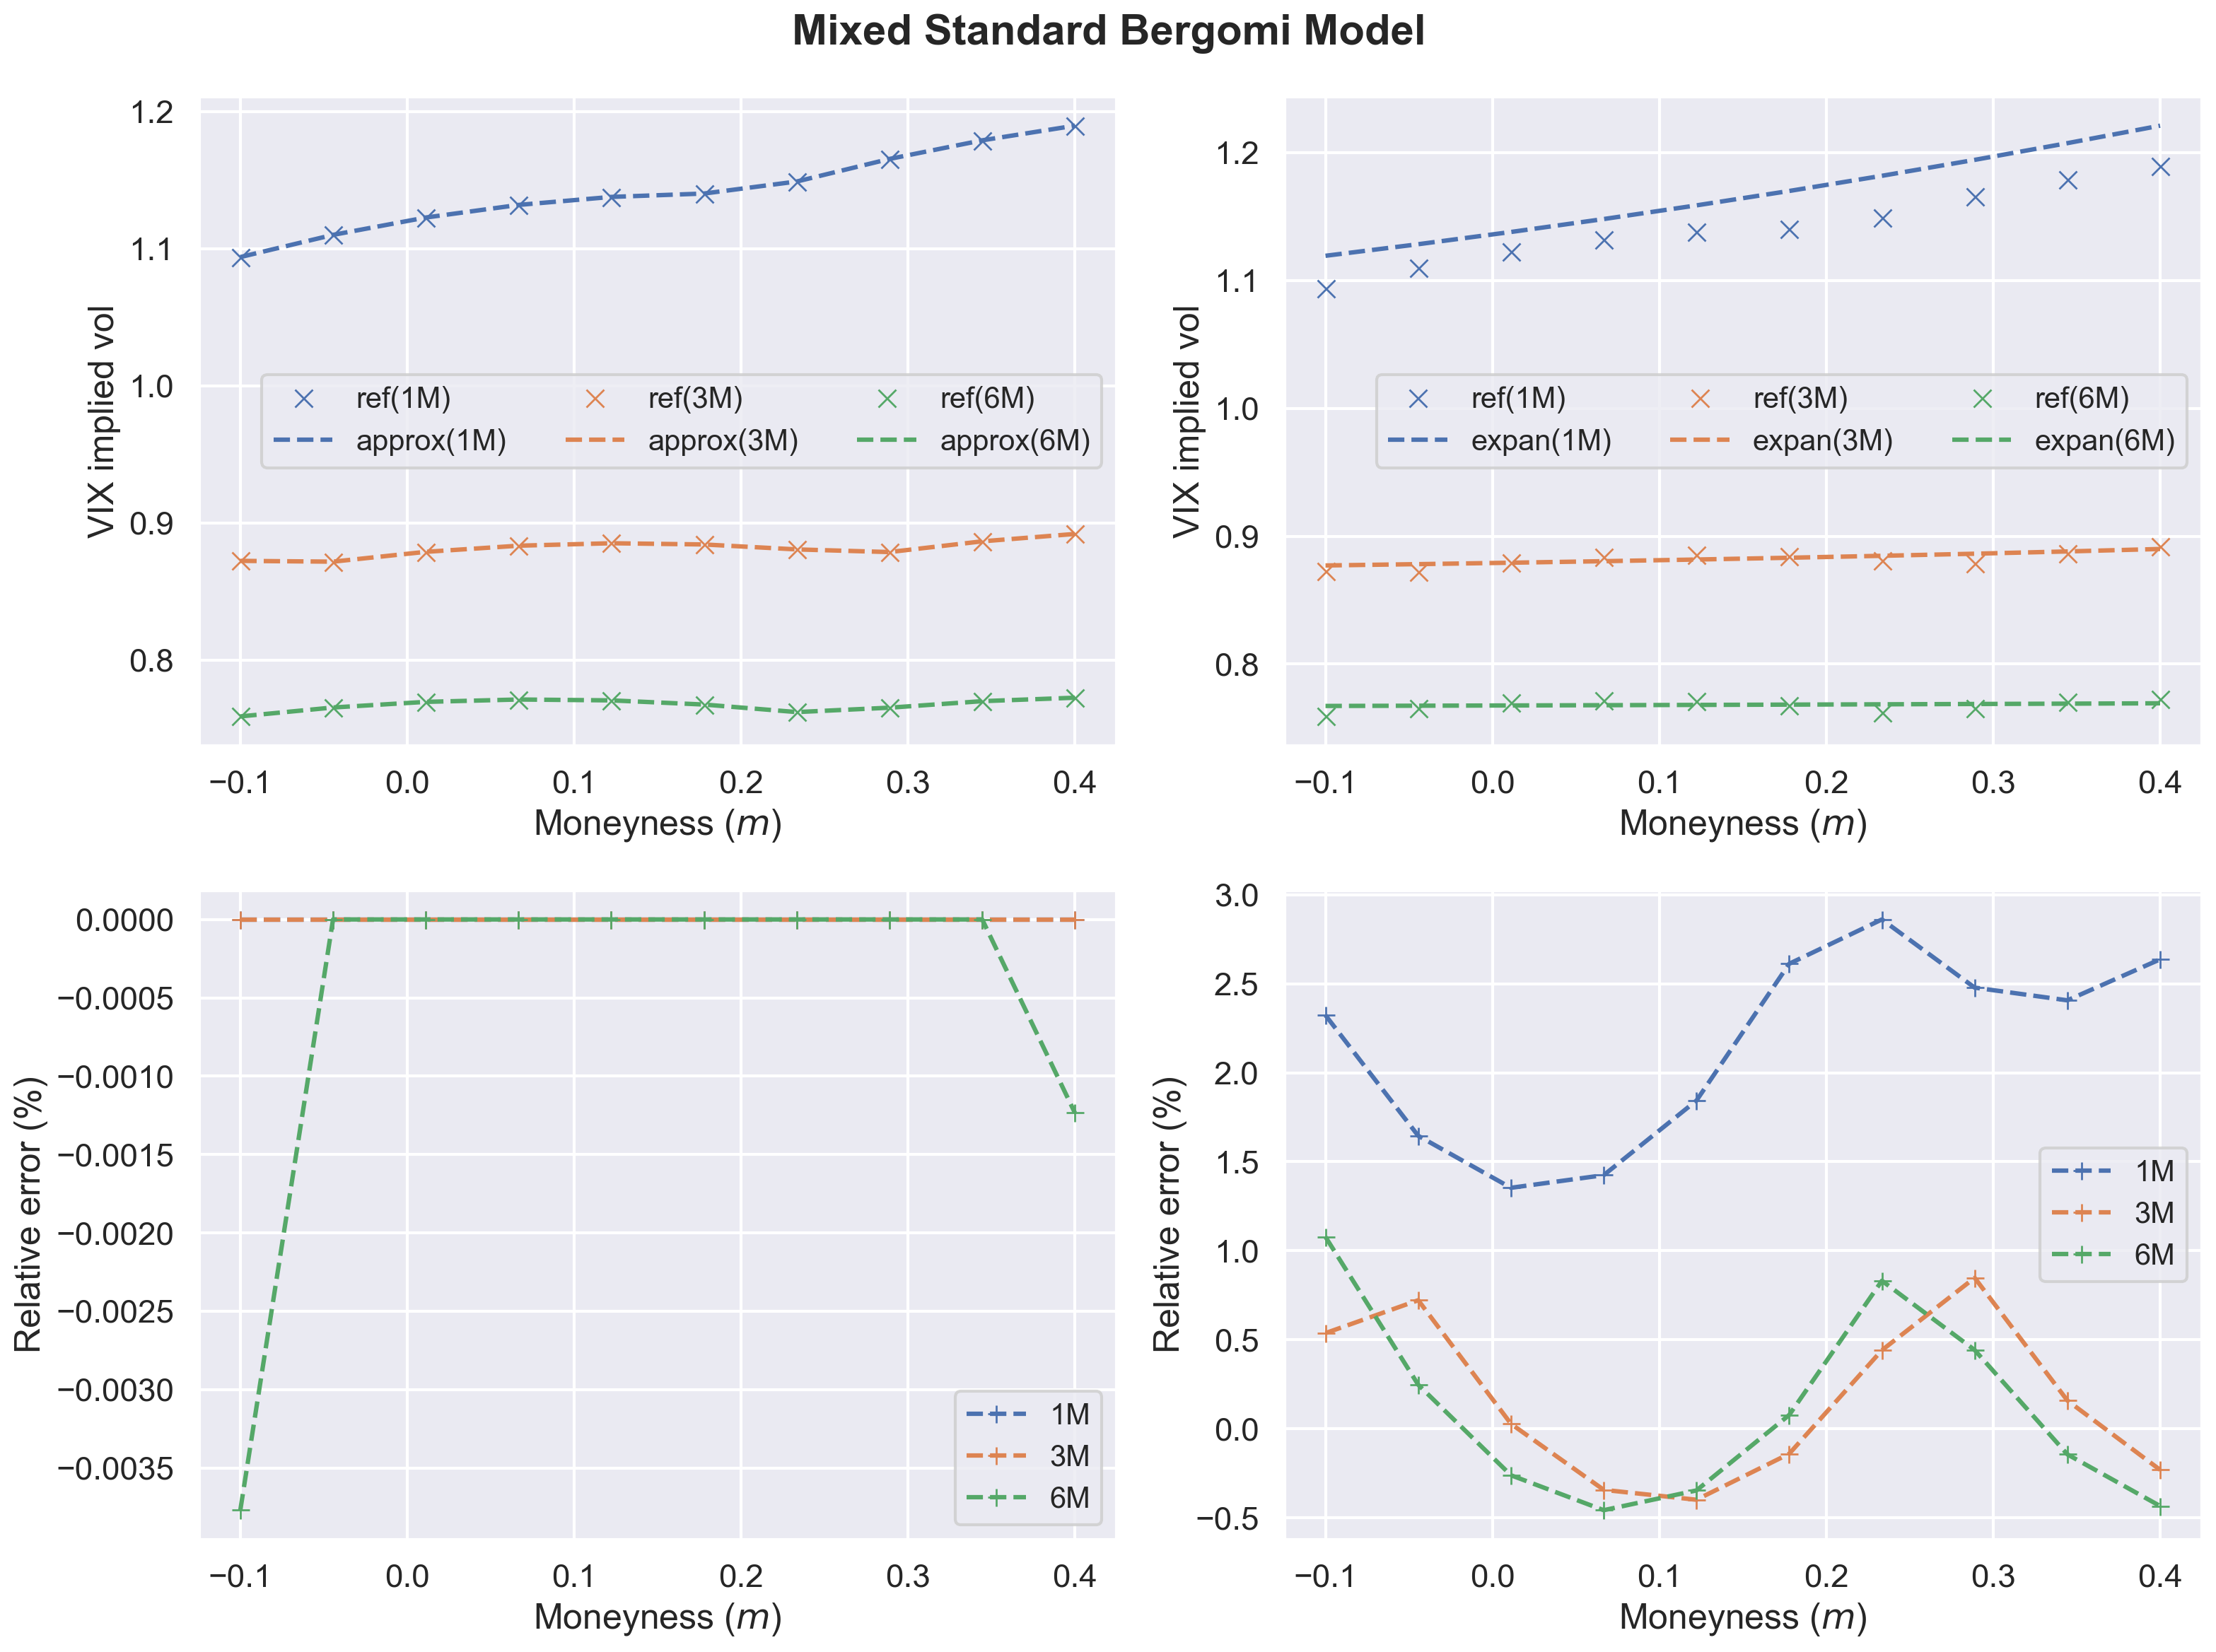

In [15]:
results_mb = {}
for label, config in calc_methods.items():
    func_name = config["method"]
    kwargs = config["kwargs"]
    method = getattr(mb, func_name)

    def run_model(k_input, T_input):
        return method(k_input, T_input, **kwargs)

    atm_iv = {mat: run_model(0, T) for mat, T in maturities.items()}
    k_val = {mat: m * atm_iv[mat] * np.sqrt(T) for mat, T in maturities.items()}
    results_mb[label] = {mat: run_model(k_val[mat], T) for mat, T in maturities.items()}

utils.plot_style_4(
    m, maturities, 
    results_mb["Ref"], results_mb["Proxy"], results_mb["Expan"], 
    "Moneyness ($m$)", "VIX implied vol", "Mixed Standard Bergomi Model"
)

#### 2.2.2 Formula 2

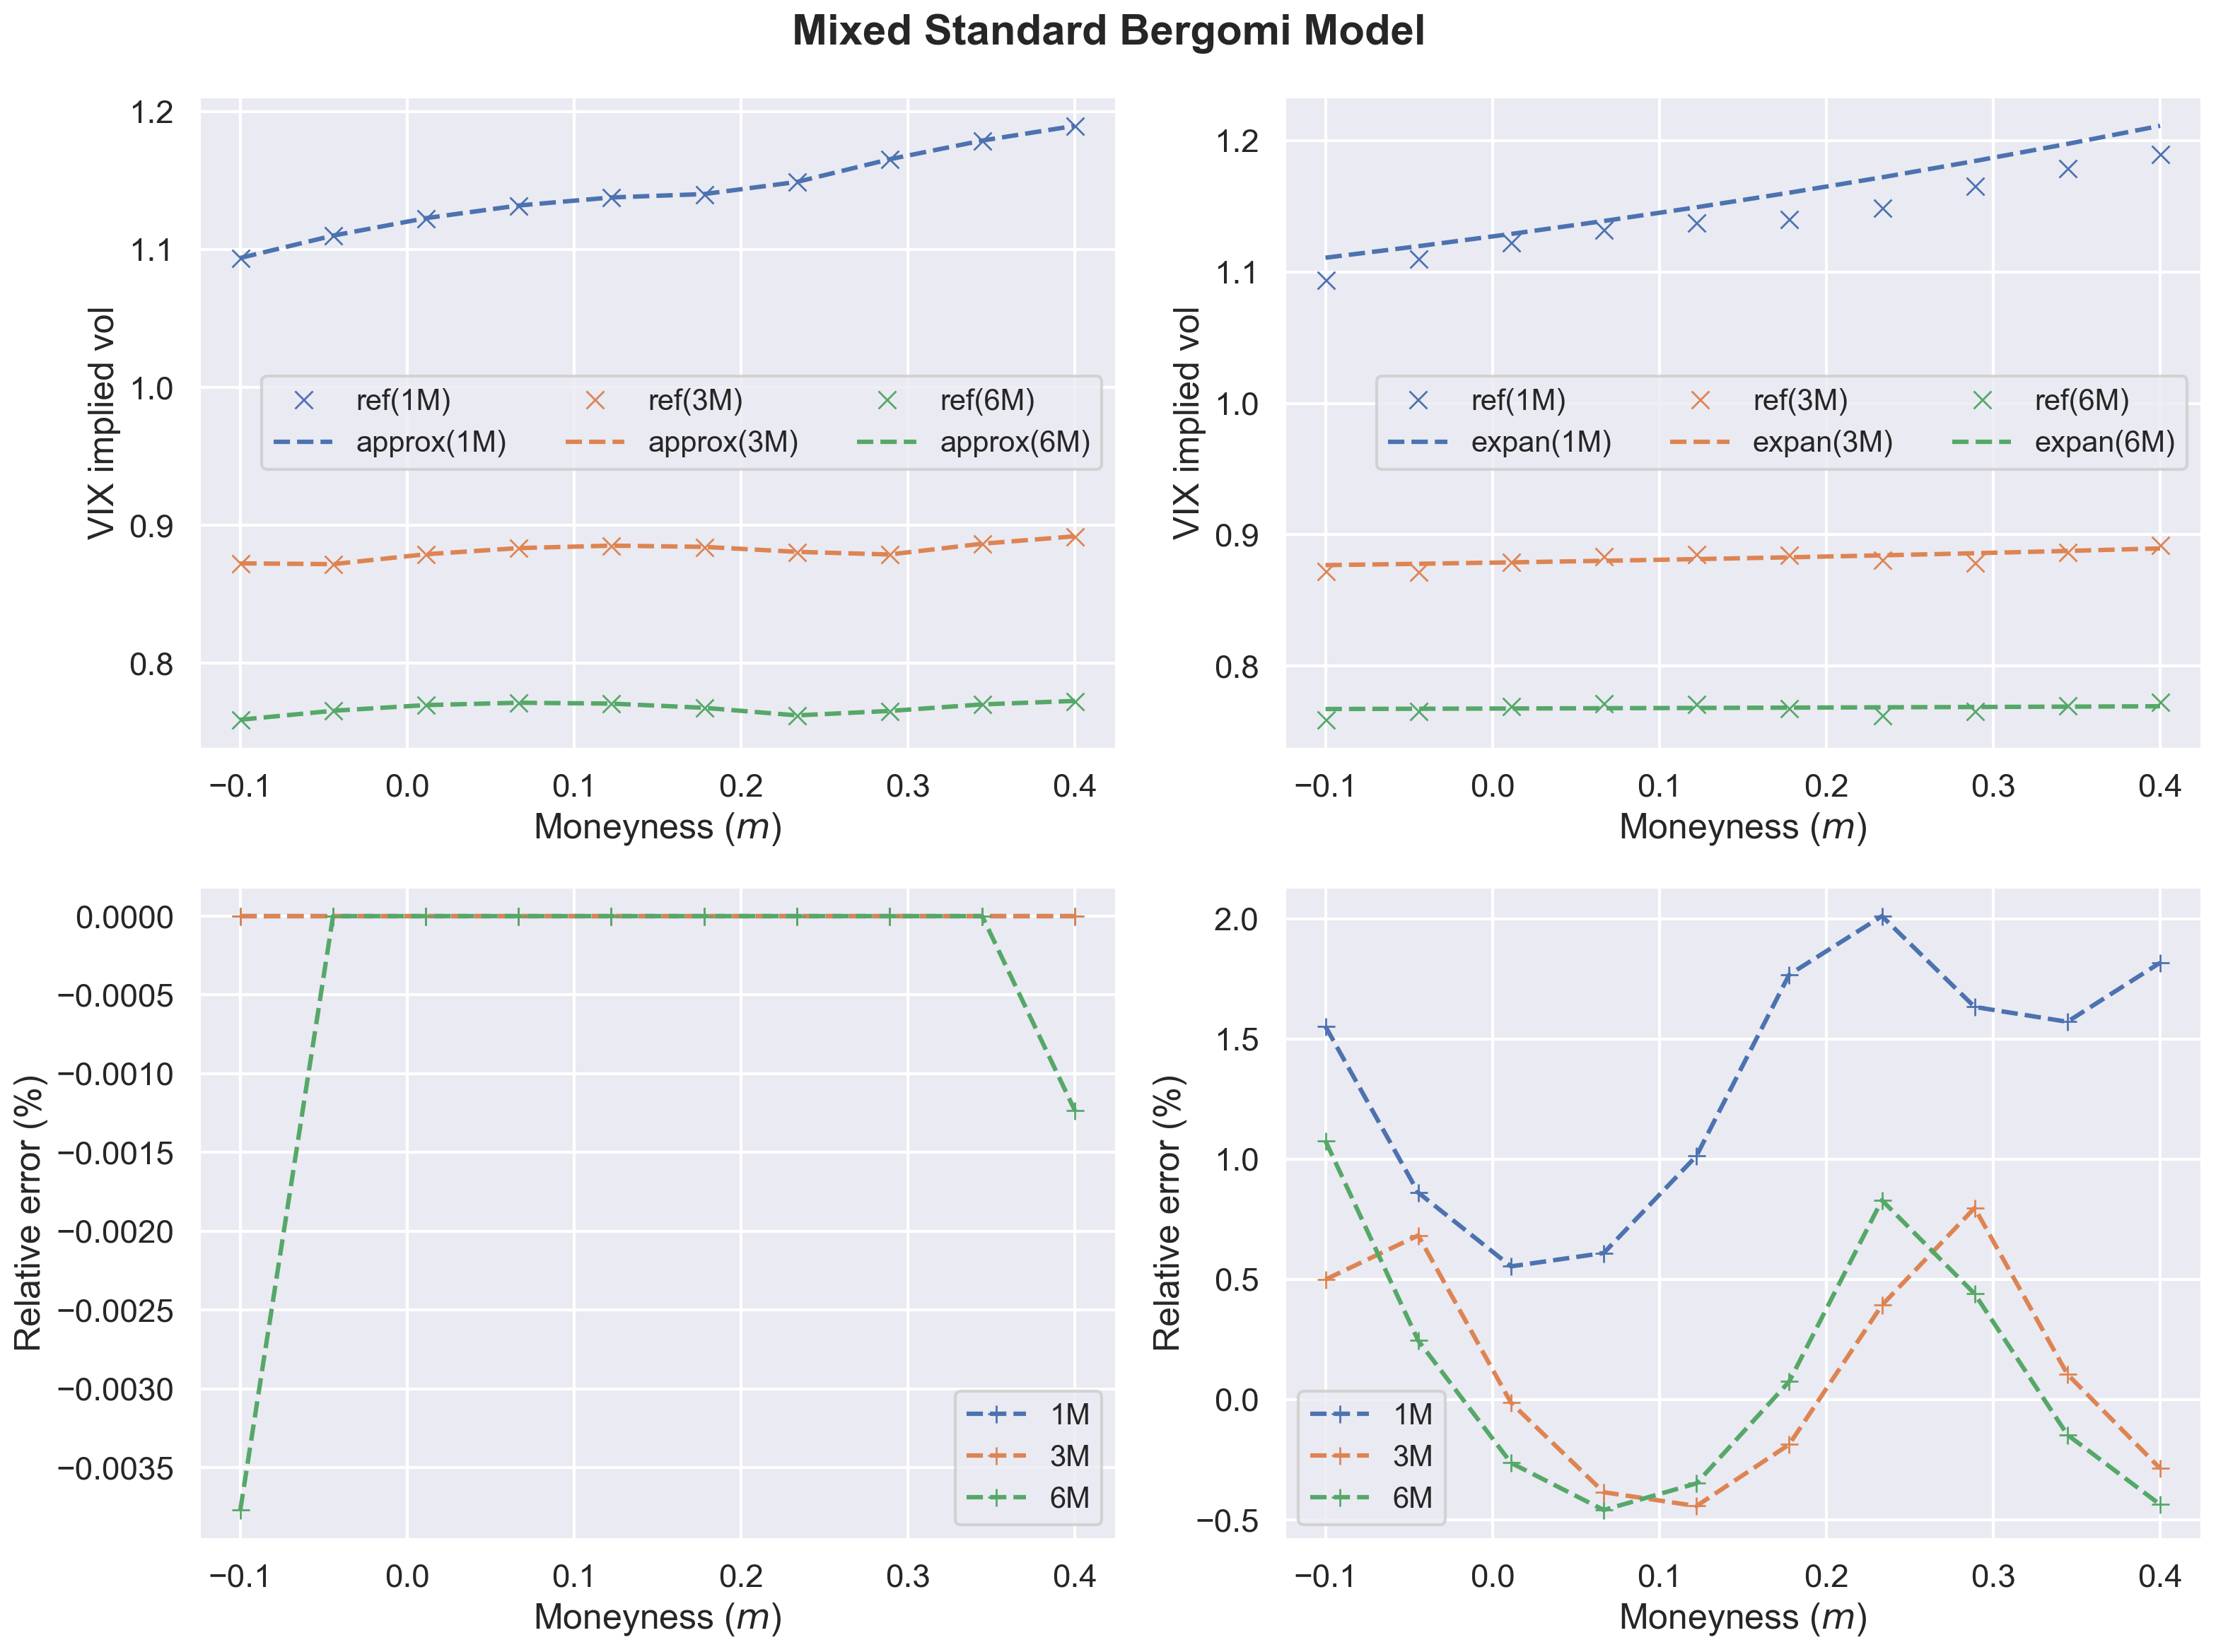

In [16]:
formula = 2

atm_iv_expan = {
    maturity: mb.implied_vol_expan_mixed(0, T, rule, omega2, lbd, n_max, n_mc, formula) for maturity, T in maturities.items()
}

k_expan = {
    maturity: m * atm_iv_expan[maturity] * np.sqrt(T) for maturity, T in maturities.items()
}

iv_expan = {
    maturity: mb.implied_vol_expan_mixed(k_expan[maturity], T, rule, omega2, lbd, n_max, n_mc, formula) for maturity, T in maturities.items()
}

utils.plot_style_4(m, maturities, results_mb["Ref"], results_mb["Proxy"], iv_expan, "Moneyness ($m$)", "VIX implied vol", "Mixed Standard Bergomi Model")

#### 2.2.3 Formula 3

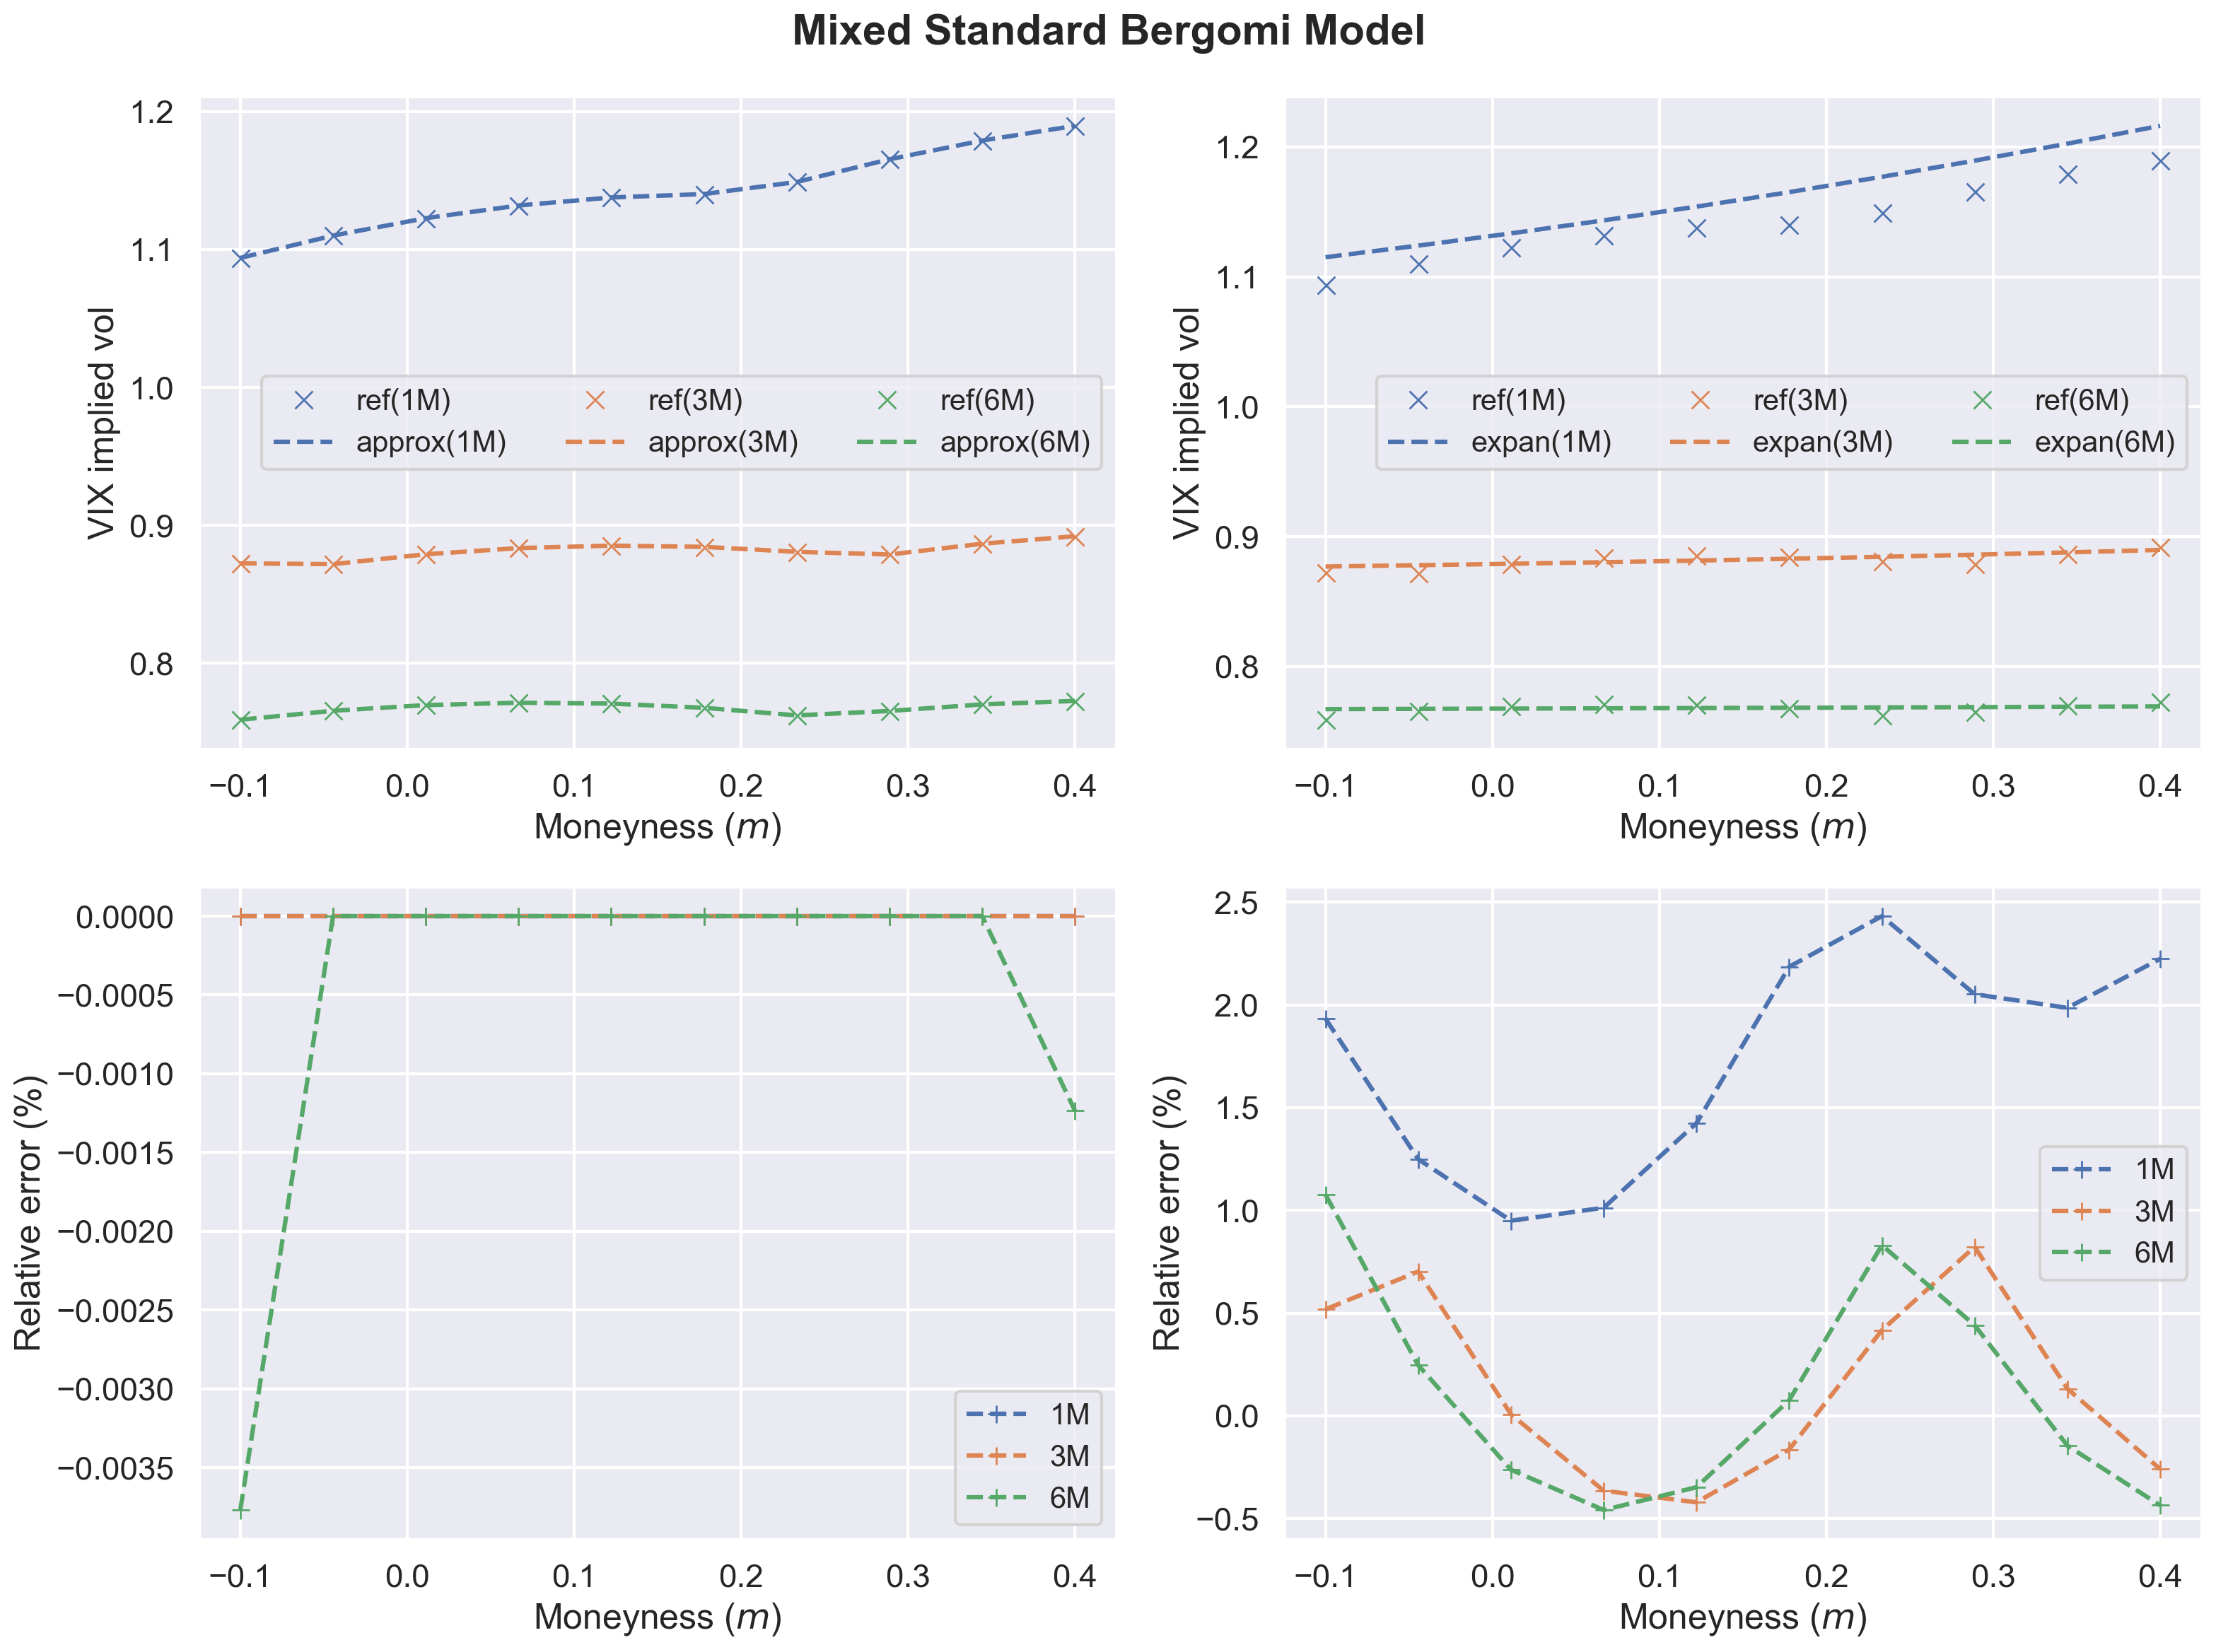

In [17]:
formula = 3

atm_iv_expan = {
    maturity: mb.implied_vol_expan_mixed(0, T, rule, omega2, lbd, n_max, n_mc, formula) for maturity, T in maturities.items()
}

k_expan = {
    maturity: m * atm_iv_expan[maturity] * np.sqrt(T) for maturity, T in maturities.items()
}

iv_expan = {
    maturity: mb.implied_vol_expan_mixed(k_expan[maturity], T, rule, omega2, lbd, n_max, n_mc, formula) for maturity, T in maturities.items()
}

utils.plot_style_4(m, maturities, results_mb["Ref"], results_mb["Proxy"], iv_expan, "Moneyness ($m$)", "VIX implied vol", "Mixed Standard Bergomi Model")

### 2.3 VIX call option price with respect to the strike price $\kappa$ in the mixed rough Bergomi model

In [18]:
params_mrb = {
    "eta": 1.4,
    "H": 0.1,
    "xi0": lambda u: np.ones_like(u) * 0.235**2
}
eta2 = 0.7
lbd = 0.3

n_disc = 300
n_max = 20

mrb = RoughBergomi(**params_mrb)

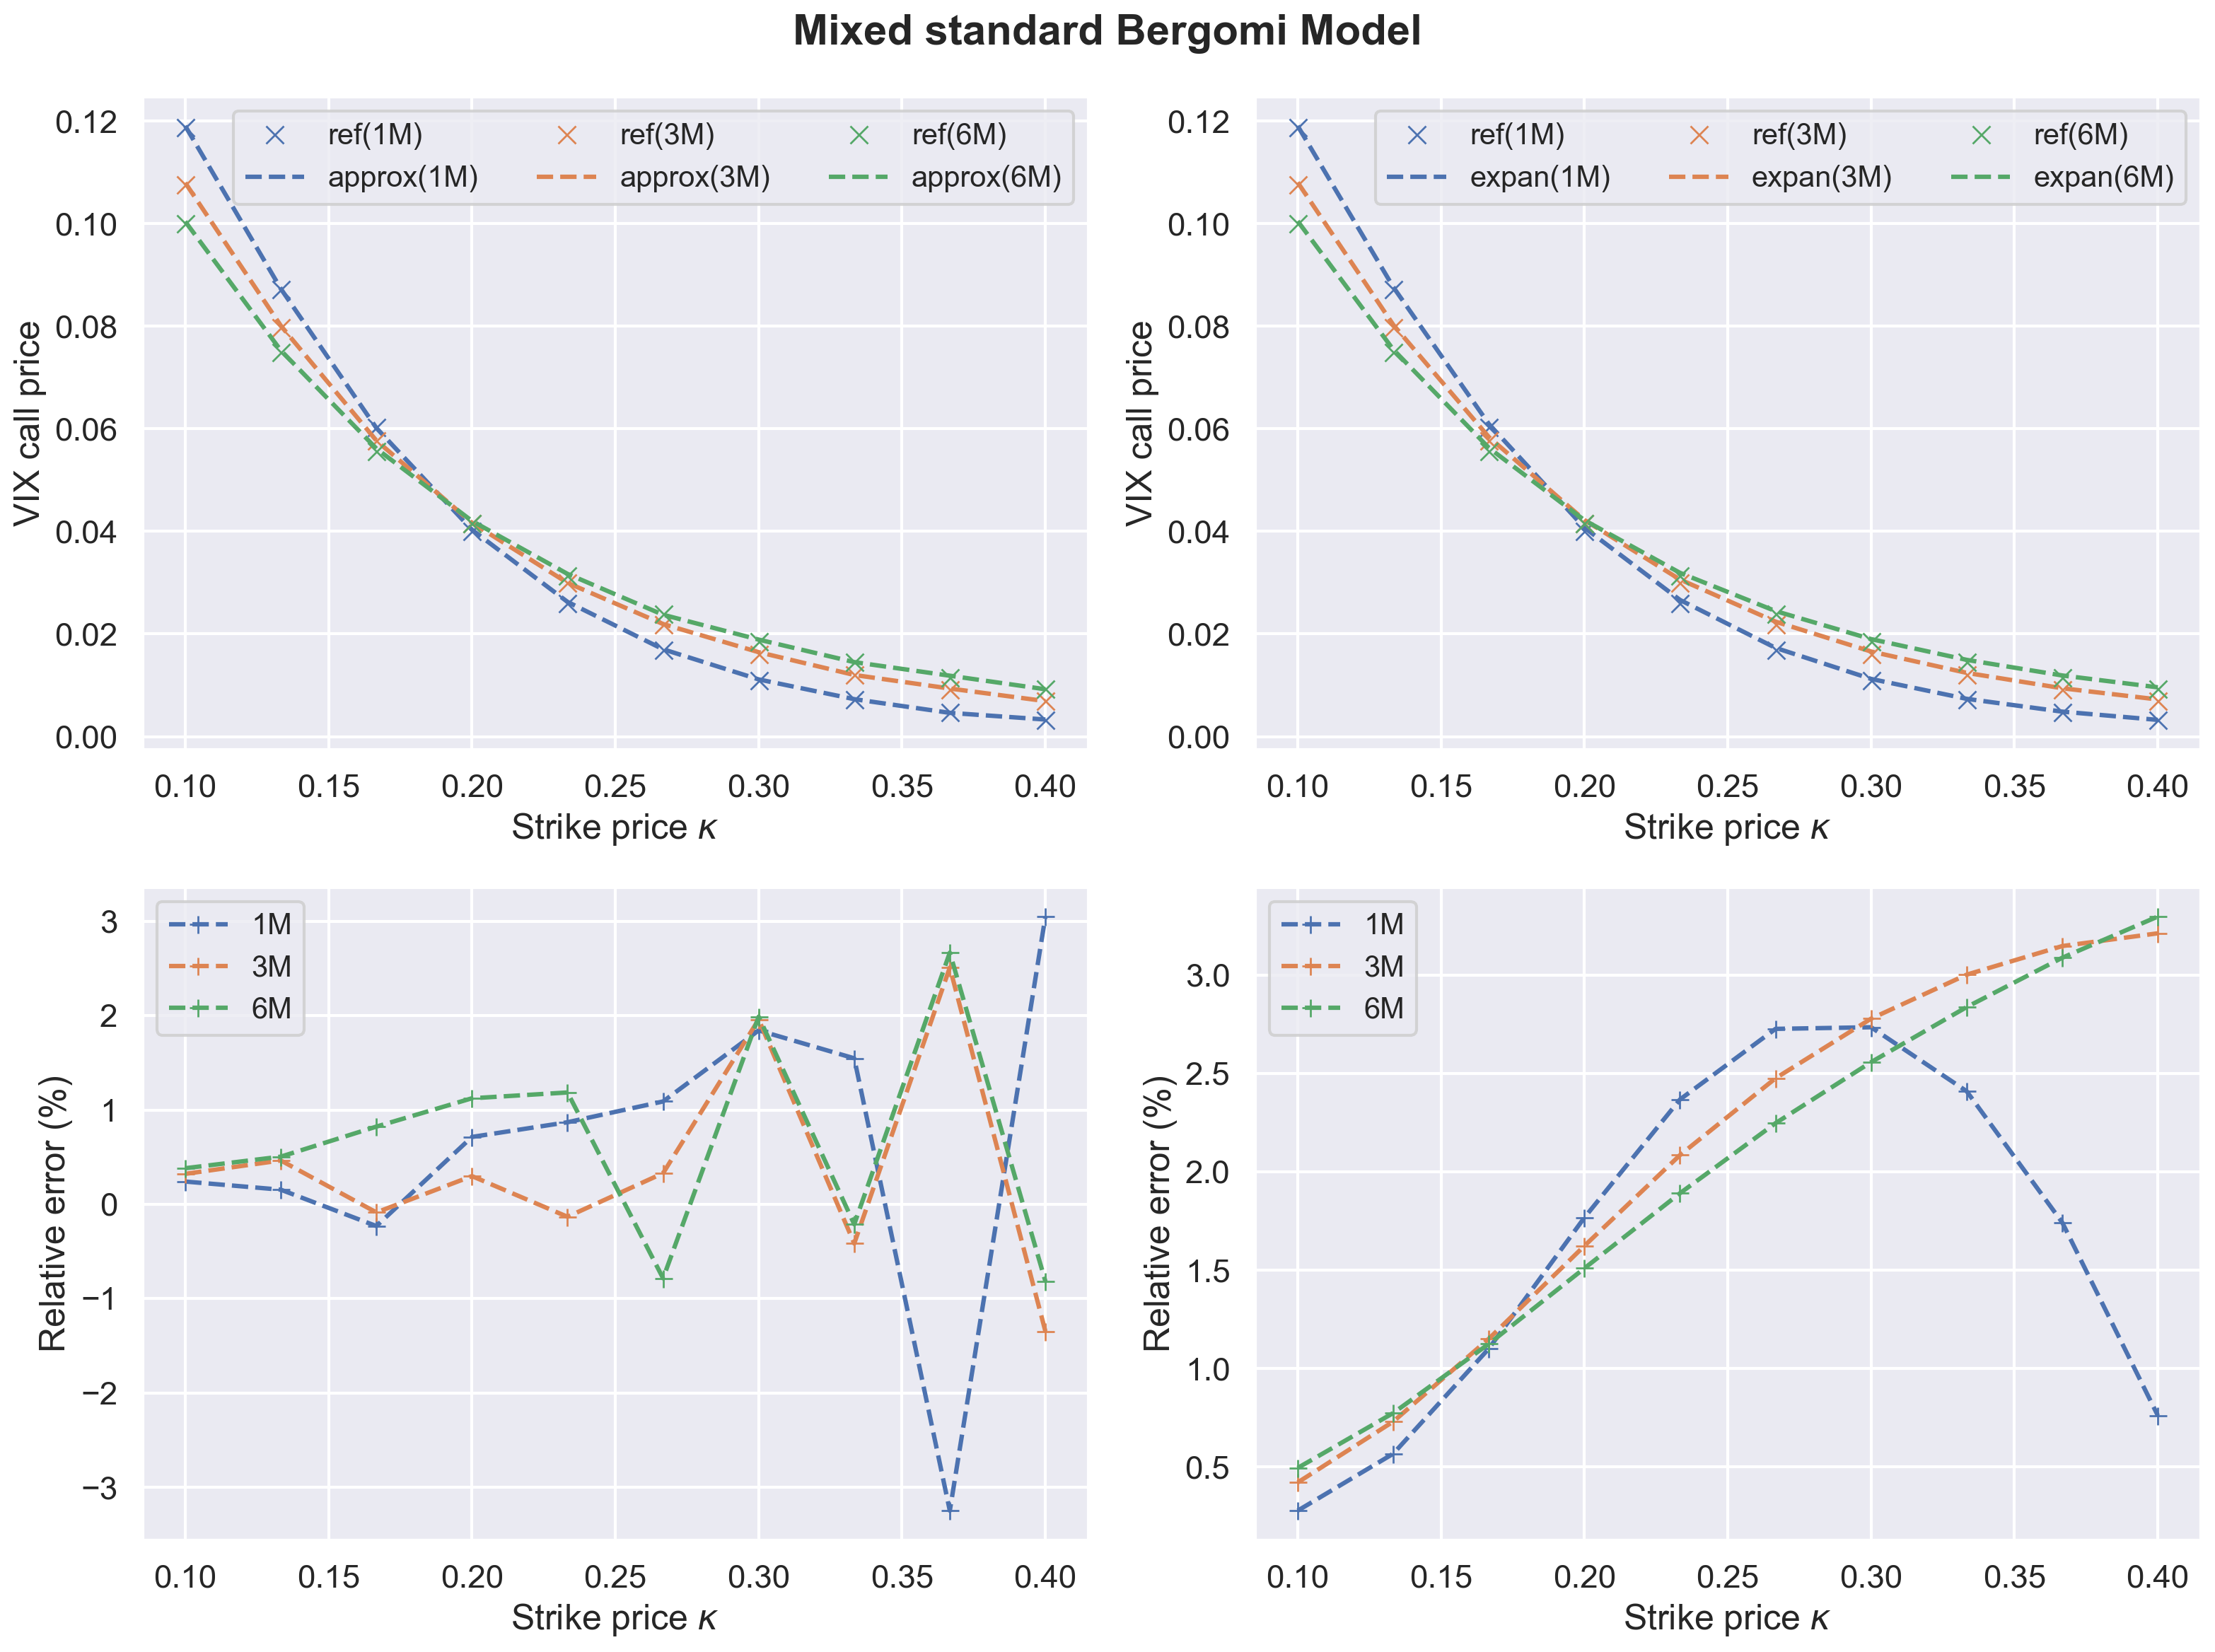

In [19]:
price_ref = {
    maturity: mrb.vix_opt_price_mixed(kappa, T, eta2, lbd, opttype=1, n_disc=n_disc, n_mc=n_mc, seed=SEED) for maturity, T in maturities.items()
}

price_proxy = {
    maturity: mrb.vix_opt_price_proxy_mixed(kappa, T, eta2, lbd, opttype=1, n_gauss=n_gauss) for maturity, T in maturities.items()
}

price_expan = {
    maturity: mrb.vix_opt_price_expan_mixed(kappa, T, rule, eta2, lbd, opttype=1, n_max=n_max, n_mc=n_mc) for maturity, T in maturities.items()
}

utils.plot_style_4(kappa, maturities, price_ref, price_proxy, price_expan, r"Strike price $\kappa$", "VIX call price", "Mixed standard Bergomi Model")

#### VIX implied volatility with respect to the moneyness $m = \frac{\log (\kappa/ F)}{\sigma_{\text{ATM}} \sqrt{T}}$ in the mixed rough Bergomi model

##### Formula 1

In [20]:
formula = 1

calc_methods = {
    "Ref": {
        "method": "vix_implied_vol_mixed",
        "kwargs": {"eta2": eta2, "lbd": lbd, "n_disc": n_disc, "n_mc": n_mc, "seed": SEED},
    },
    "Proxy": {
        "method": "implied_vol_proxy_mixed",
        "kwargs": {"eta2": eta2, "lbd": lbd, "n_gauss": n_gauss},
    },
    "Expan": {
        "method": "implied_vol_expan_mixed",
        "kwargs": {"rule": rule, "eta2": eta2, "lbd": lbd, "n_max": n_max, "n_mc": n_mc, "formula": formula},
    }
}

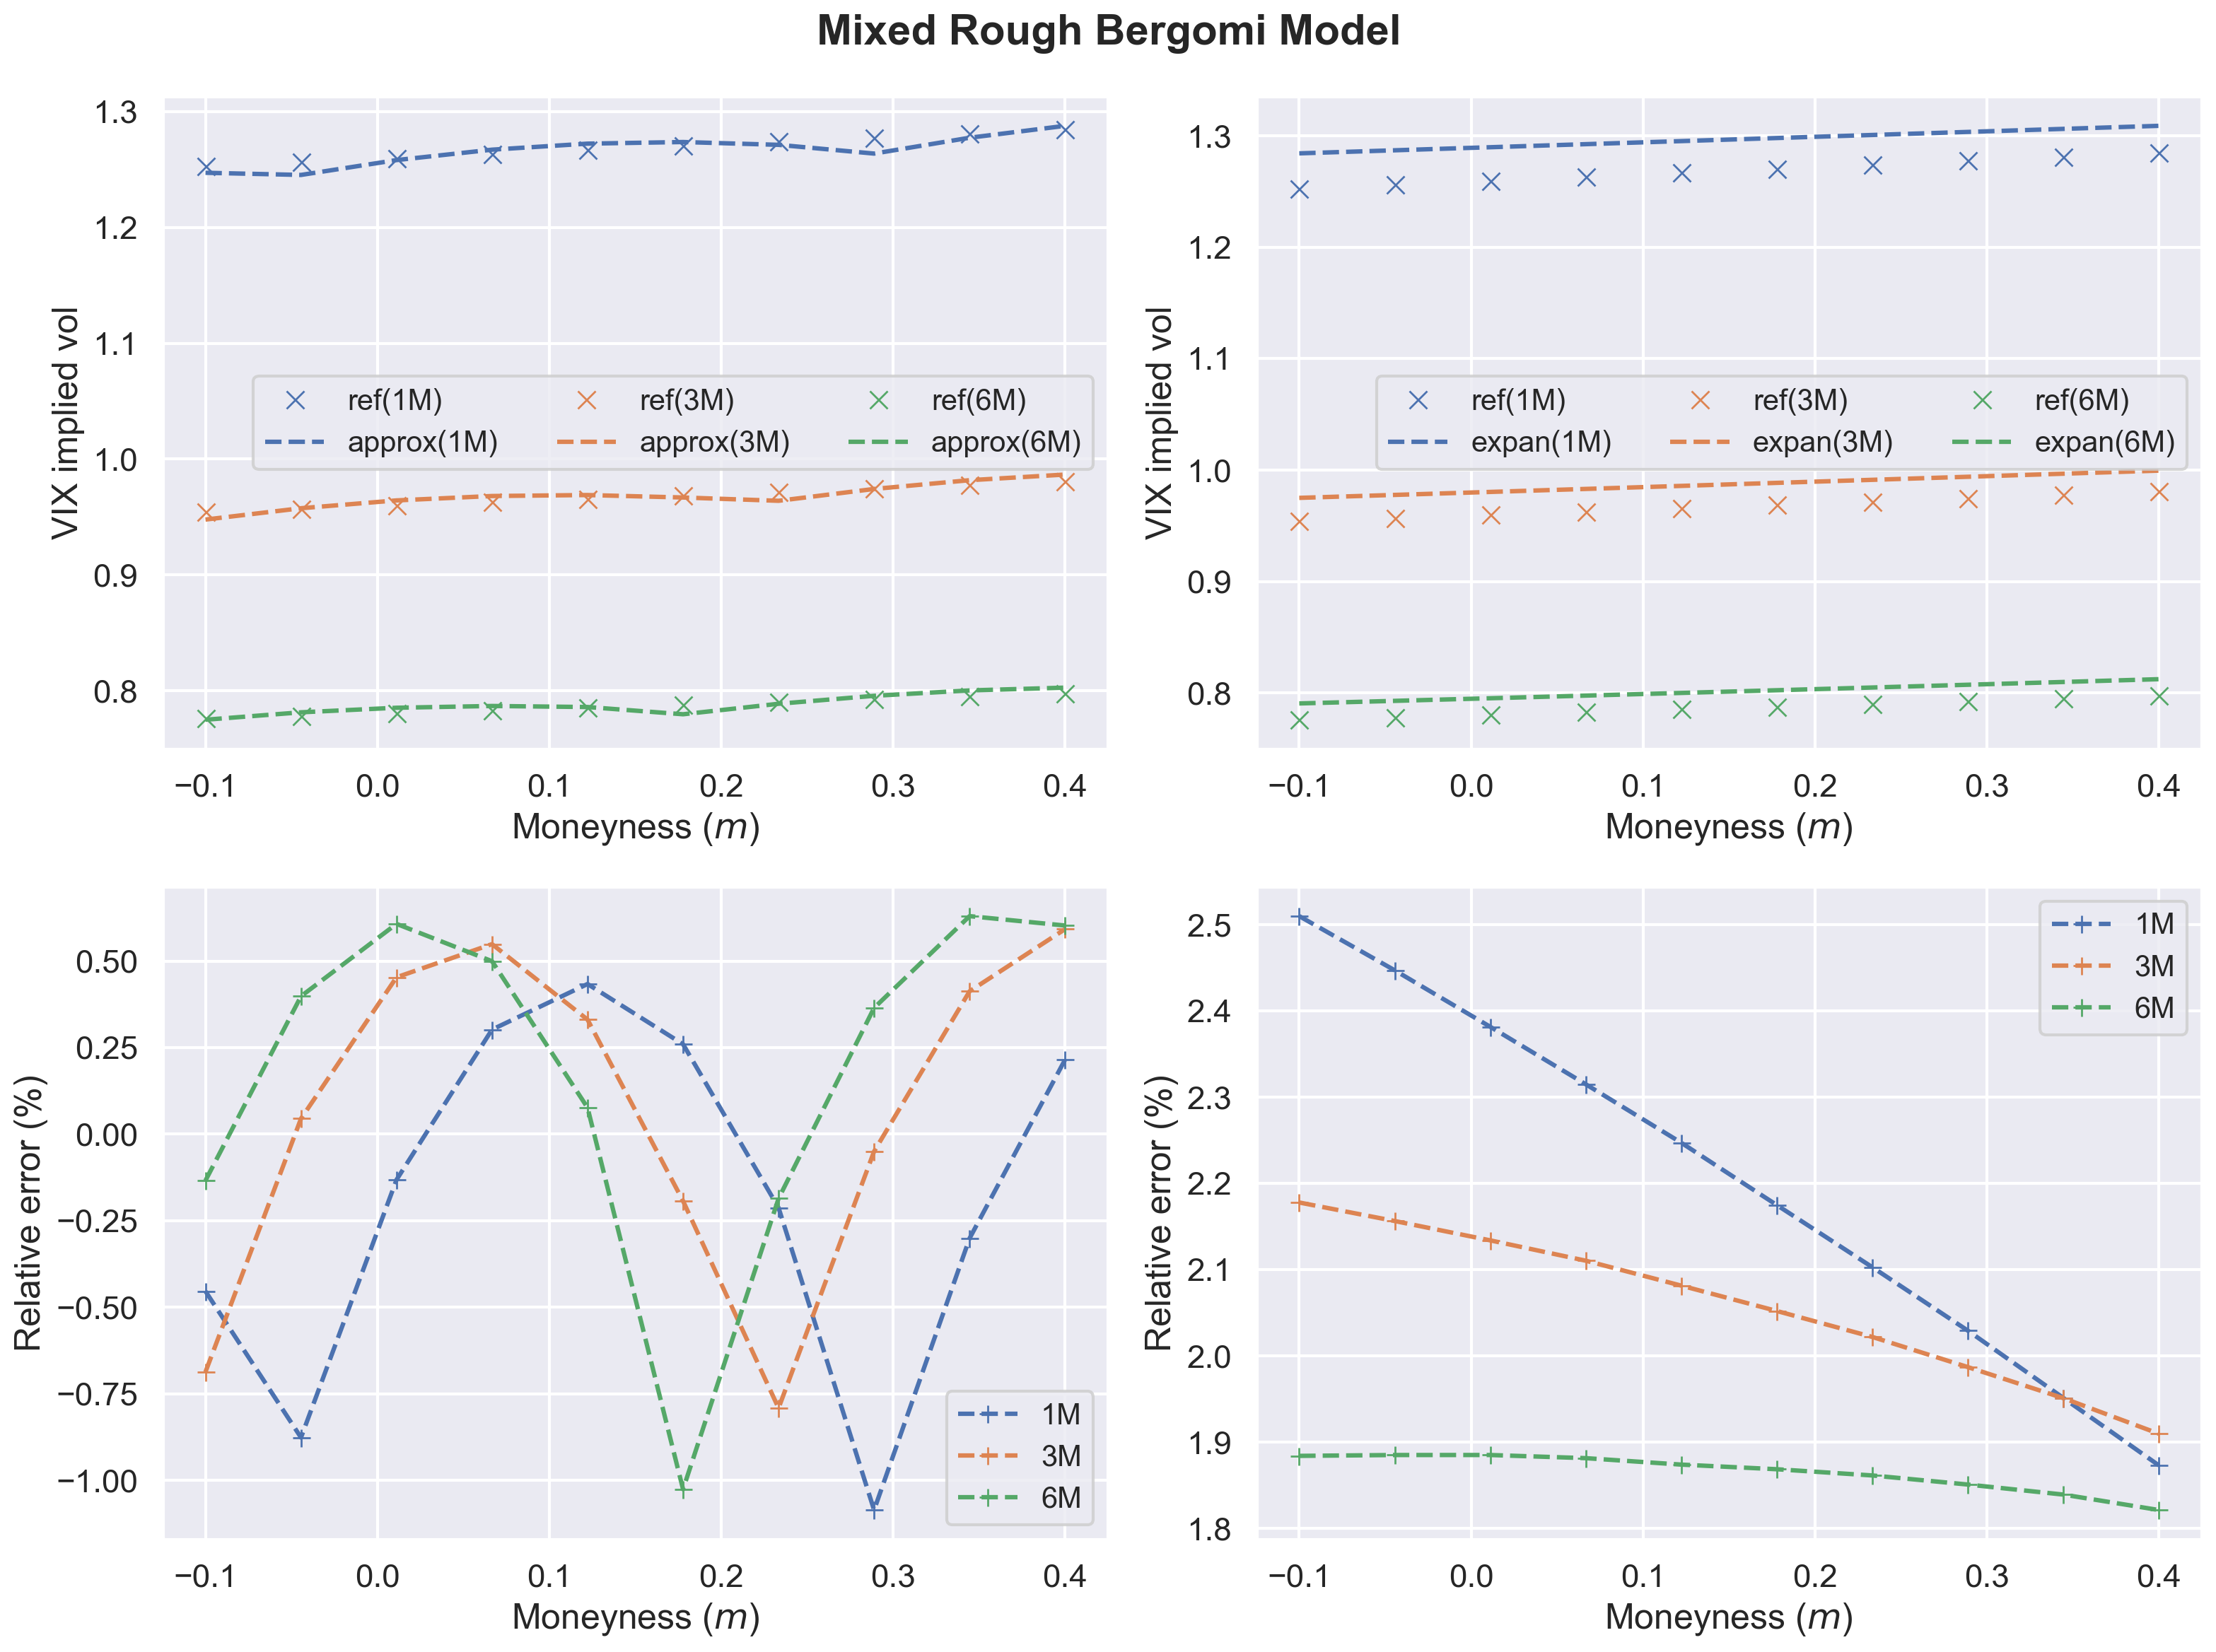

In [21]:
results_mrb = {}
for label, config in calc_methods.items():
    func_name = config["method"]
    kwargs = config["kwargs"]
    method = getattr(mrb, func_name)

    def run_model(k_input, T_input):
        return method(k_input, T_input, **kwargs)

    atm_iv = {mat: run_model(0, T) for mat, T in maturities.items()}
    k_val = {mat: m * atm_iv[mat] * np.sqrt(T) for mat, T in maturities.items()}
    results_mrb[label] = {mat: run_model(k_val[mat], T) for mat, T in maturities.items()}

utils.plot_style_4(
    m, maturities, 
    results_mrb["Ref"], results_mrb["Proxy"], results_mrb["Expan"], 
    "Moneyness ($m$)", "VIX implied vol", "Mixed Rough Bergomi Model"
)

##### Formula 2

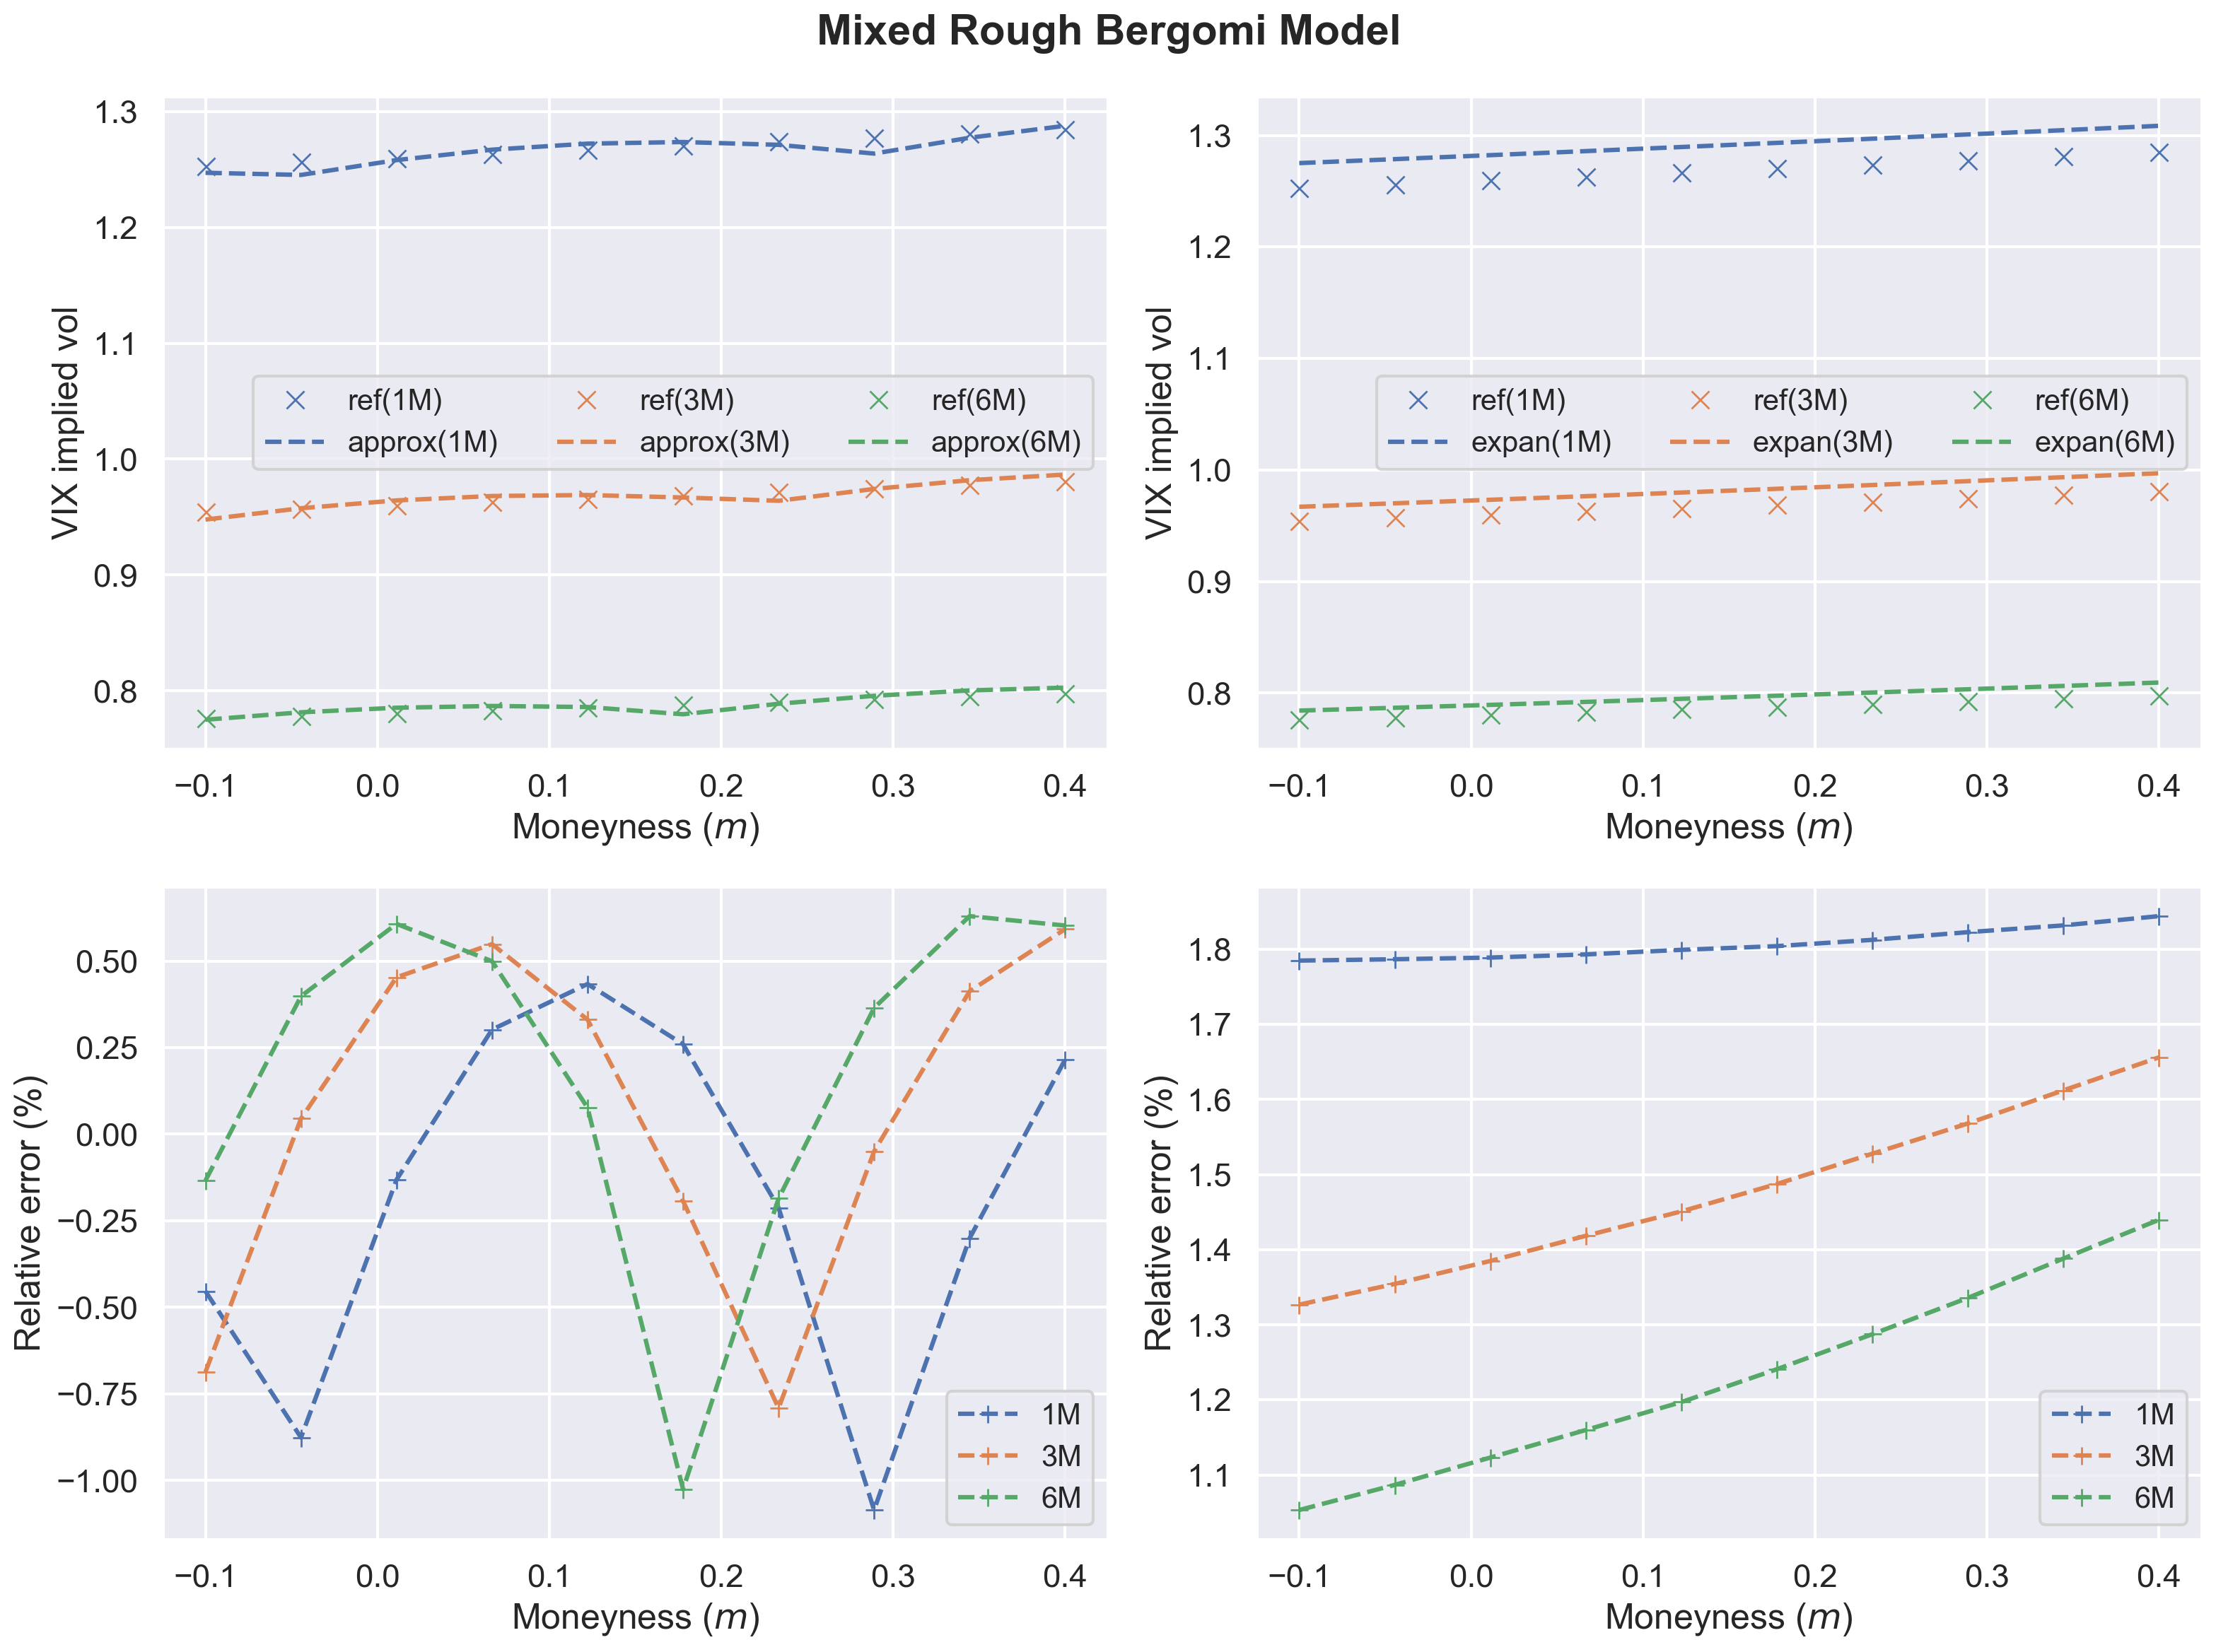

In [22]:
formula = 2

atm_iv_expan = {
    maturity: mrb.implied_vol_expan_mixed(0, T, rule, eta2, lbd, n_max, n_mc, formula) for maturity, T in maturities.items()
}

k_expan = {
    maturity: m * atm_iv_expan[maturity] * np.sqrt(T) for maturity, T in maturities.items()
}

iv_expan = {
    maturity: mrb.implied_vol_expan_mixed(k_expan[maturity], T, rule, eta2, lbd, n_max, n_mc, formula) for maturity, T in maturities.items()
}

utils.plot_style_4(m, maturities, results_mrb["Ref"], results_mrb["Proxy"], iv_expan, "Moneyness ($m$)", "VIX implied vol", "Mixed Rough Bergomi Model")

##### Formula 3

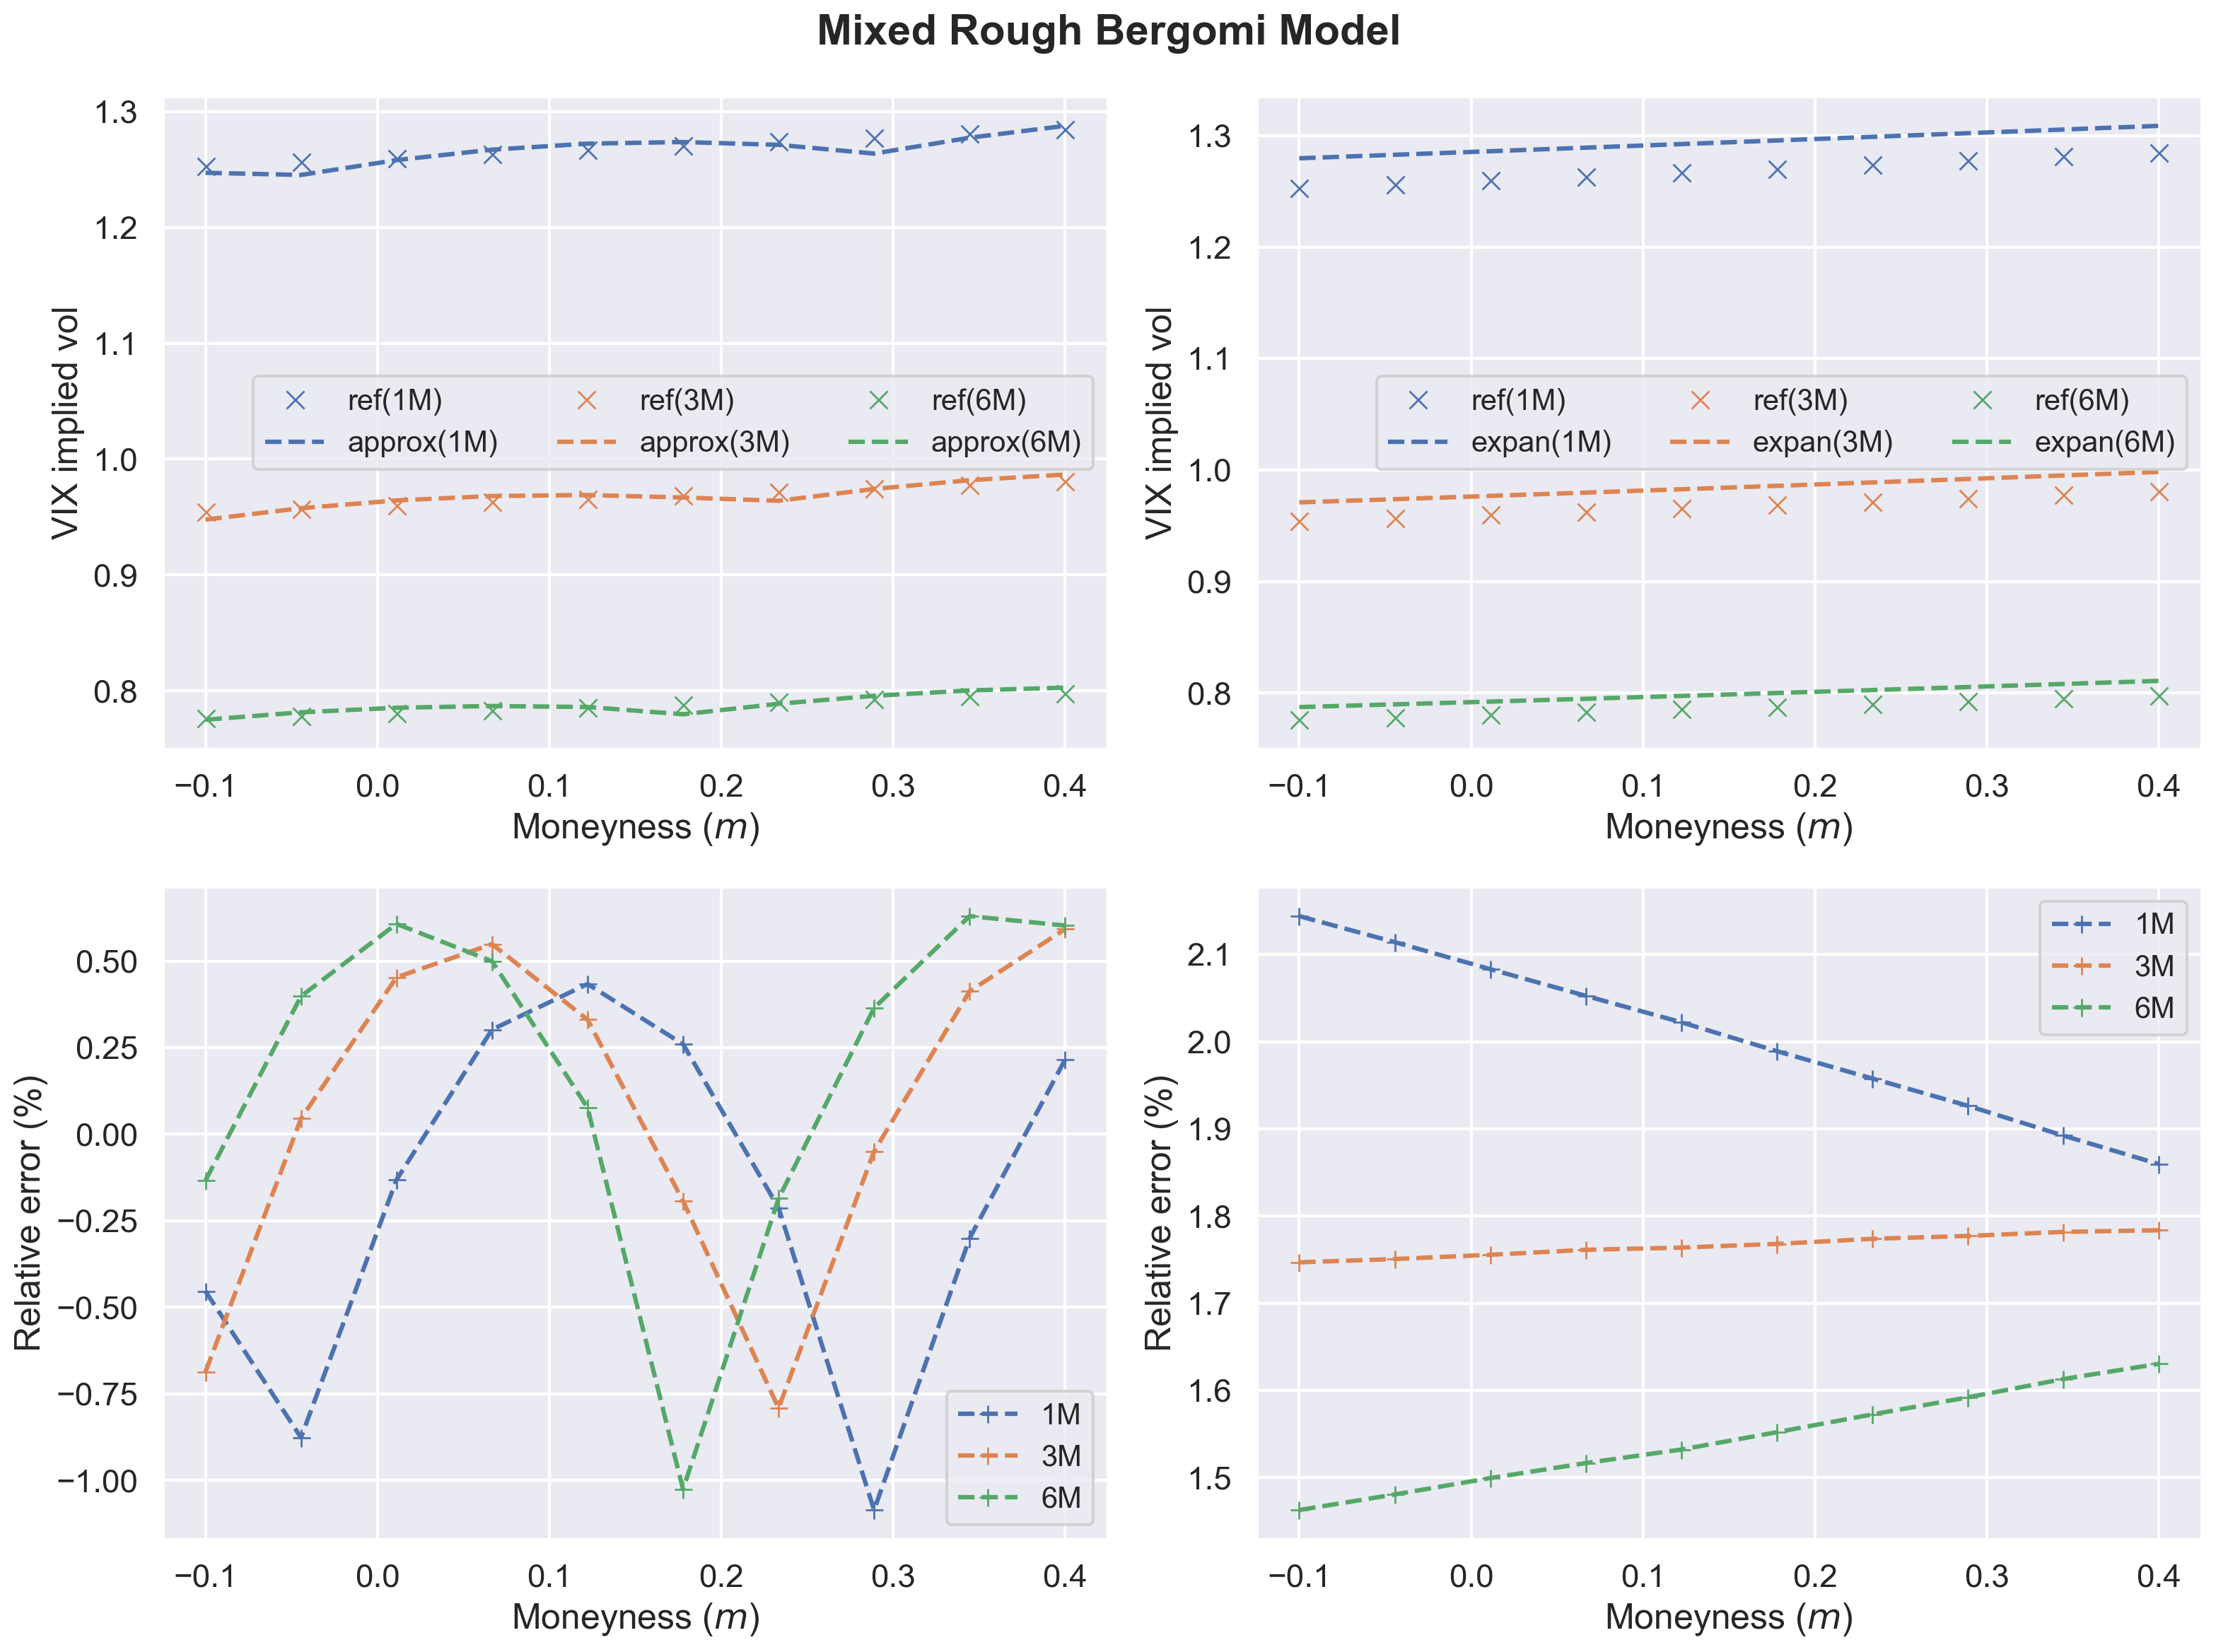

In [23]:
formula = 3

atm_iv_expan = {
    maturity: mrb.implied_vol_expan_mixed(0, T, rule, eta2, lbd, n_max, n_mc, formula) for maturity, T in maturities.items()
}

k_expan = {
    maturity: m * atm_iv_expan[maturity] * np.sqrt(T) for maturity, T in maturities.items()
}

iv_expan = {
    maturity: mrb.implied_vol_expan_mixed(k_expan[maturity], T, rule, eta2, lbd, n_max, n_mc, formula) for maturity, T in maturities.items()
}

utils.plot_style_4(m, maturities, results_mrb["Ref"], results_mrb["Proxy"], iv_expan, "Moneyness ($m$)", "VIX implied vol", "Mixed Rough Bergomi Model")

#### Computation time of the explicit VIX implied volatility approximation

In [24]:
import time
k0 = 0.1
T = 3.0 / 12.0

In [25]:
start = time.perf_counter()
mb.implied_vol_proxy_mixed(k0, T, omega2, lbd, n_gauss)
elapsed = time.perf_counter() - start
print(f"The root-finding method took {elapsed*1000:.6f} ms.")

start = time.perf_counter()
mb.implied_vol_expan_mixed(k0, T, rule, omega2, lbd, n_max, n_mc, formula)
elapsed = time.perf_counter() - start
print(f"The closed-form formula took {elapsed*1000:.6f} ms.")

The root-finding method took 3.563000 ms.
The closed-form formula took 3604.263200 ms.


In [26]:
start = time.perf_counter()
mrb.implied_vol_proxy_mixed(k0, T, eta2, lbd, n_gauss)
elapsed = time.perf_counter() - start
print(f"The root-finding method took {elapsed*1000:.6f} ms.")

start = time.perf_counter()
mrb.implied_vol_expan_mixed(k0, T, rule, eta2, lbd, n_max, n_mc, formula)
elapsed = time.perf_counter() - start
print(f"The closed-form formula took {elapsed*1000:.6f} ms.")

The root-finding method took 1651.602000 ms.
The closed-form formula took 3314.212700 ms.


If the optimal order is fixed to 10, which means that we don't need to find the optimal order of the hermite expansion, the computaion time is shorter.

In [27]:
start = time.perf_counter()
mrb.implied_vol_expan_mixed(k0, T, rule, eta2, lbd, n_max, n_mc, formula, optimal_n=10)
elapsed = time.perf_counter() - start
print(f"The closed-form formula took {elapsed*1000:.6f} ms.")

The closed-form formula took 1419.376600 ms.
